## Figure 1B, 1C
## Figure S1, S2, S3, S5A

In [1]:
# from pynwb import NWBHDF5IO
from scipy.io import savemat, loadmat
import mat73
import hdf5storage as st
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from scipy.sparse.linalg import eigsh
from scipy.stats import wilcoxon, kruskal, mannwhitneyu, sem
from scipy.optimize import curve_fit

import seaborn as sns
from copy import deepcopy as dc
from statsmodels.stats.multitest import multipletests

from itertools import combinations
import math
from umap import UMAP

# # tell pandas to show all columns when we display a DataFrame
# pd.set_option("display.max_columns", None)

c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# loading variables

# ABO Neuropixels
with open('resp_matrix_ep_RS_all_32sess_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_RS_all = pickle.load(f)

    list_rate_RS = resp_matrix_ep_RS_all['list_rate_RS'].copy()
    list_rate_RS_dr = resp_matrix_ep_RS_all['list_rate_RS_dr'].copy()
    list_rate_all = resp_matrix_ep_RS_all['list_rate_all'].copy()
    list_rate_all_dr = resp_matrix_ep_RS_all['list_rate_all_dr'].copy()
    list_slopes_RS_an_loglog = resp_matrix_ep_RS_all['list_slopes_RS_an_loglog'].copy()
    list_slopes_all_an_loglog = resp_matrix_ep_RS_all['list_slopes_all_an_loglog'].copy()
    list_slopes_stat_all_an_loglog = resp_matrix_ep_RS_all['list_slopes_stat_all_an_loglog'].copy()
    list_slopes_mov_all_an_loglog = resp_matrix_ep_RS_all['list_slopes_mov_all_an_loglog'].copy()

    sess_inds_qual_RS = resp_matrix_ep_RS_all['sess_inds_qual_RS'].copy()
    sess_inds_qual_RS_dr = resp_matrix_ep_RS_all['sess_inds_qual_RS_dr'].copy()
    sess_inds_qual_all = resp_matrix_ep_RS_all['sess_inds_qual_all'].copy()
    sess_inds_qual_all_dr = resp_matrix_ep_RS_all['sess_inds_qual_all_dr'].copy()

    print(resp_matrix_ep_RS_all['tree_variables'])

['list_rate_RS', 'list_rate_RS_dr', 'list_rate_all', 'list_rate_all_dr', 'list_slopes_RS_an_loglog', 'list_slopes_all_an_loglog', 'list_slopes_stat_all_an_loglog', 'list_slopes_mov_all_an_loglog', 'sess_inds_qual_RS', 'sess_inds_qual_RS_dr', 'sess_inds_qual_all', 'sess_inds_qual_all_dr']


In [3]:
def compute_mean_var_trial(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        if trial_rate.ndim > 1:
            trial_mean = np.mean(trial_rate, axis=1)
            trial_var = np.var(trial_rate, axis=1, ddof=1)
        else:
            trial_mean = trial_rate.copy()
            trial_var = np.zeros((trial_rate.shape[0], 1))

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = pd.concat([trial_mean] * label_cnt_dict[trial_type], axis=1)
        list_trial_var[trial_ind] = pd.concat([trial_var] * label_cnt_dict[trial_type], axis=1)

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [4]:
def compute_mean_var_trial_collapse(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        if trial_rate.ndim > 1:
            trial_mean = np.mean(trial_rate, axis=1)
            trial_var = np.var(trial_rate, axis=1, ddof=1)
        else:
            trial_mean = trial_rate.copy()
            trial_var = np.zeros((trial_rate.shape[0], 1))

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = trial_mean.copy()
        list_trial_var[trial_ind] = trial_var.copy()

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [5]:
def barplot_annotate_brackets(ind1, ind2, pvals, center, height, yerr=None, dh=.05, barh=.03, texth=0, \
                              axes=None, ax_ind=None, fs=None, maxasterix=None, str_bar=True):
    """ 
    Annotate barplot with p-values.

    ind1: index of left bar to put bracket over
    ind2: index of right bar to put bracket over
    pvals: string to write (e.g., 'p = 0.003') or p-value for generating asterixes
    center: centers of all bars (like plt.bar() input)
    height: heights of all bars (like plt.bar() input)
    yerr: yerrs of all bars (like plt.bar() input)
    dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    barh: bar height in axes coordinates (0 to 1)
    fs: font size
    maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    # asterisk text 만들기
    if type(pvals) is str:
        text = pvals
    else:
        # * is p < 0.05
        # ** is p < 0.01
        # *** is p < 0.001
        # etc.
        text = ''
        list_p = [0.05, 0.01, 0.001]

        for p in list_p:
            if pvals < p:
                text += '*'
            else:
                break

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = f'p = {pvals:.2f}'

    # barplot의 좌표
    lx, ly = center[ind1], height[ind1]
    rx, ry = center[ind2], height[ind2]

    if yerr:
        ly += yerr[ind1]
        ry += yerr[ind2]

    # ylim
    if axes is not None:
        ax_y0, ax_y1 = axes[ax_ind].get_ylim()
    else:
        ax_y0, ax_y1 = plt.gca().get_ylim()

    # significance bar의 좌표
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh
    # y = (ax_y1 - ax_y0) * 0.89

    if str_bar: # bar 양 끝 꺾임 없음
        barx = [lx, rx]
        bary = [y, y]
        mid = ((lx+rx)/2, y+texth)

    else: # bar 양 끝 꺽임 있음
        barx = [lx, lx, rx, rx]
        bary = [y, y+barh, y+barh, y]
        mid = ((lx+rx)/2, y+barh+texth)

    # text용 kwargs
    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    # significance bar 그리기
    if axes is not None:
        axes[ax_ind].plot(barx, bary, c='black')
        axes[ax_ind].text(*mid, text, **kwargs)    
    
    else:        
        plt.plot(barx, bary, c='black')
        plt.text(*mid, text, **kwargs)

In [6]:
# sessions.csv loading (includes session id)
sessions = pd.read_csv('D:\\Users\\USER\\MATLAB\\Allen_Brain_Neuropixels\\sessions.csv')
# print(sessions.loc[:, 'id'])

In [7]:
# # response matrix calculated by matlab (spike rate) loading (V1 RS neurons)
# list_rate_RS = []
# list_rate_RS_dr = []
# for sess_ind, sess_id in enumerate(sessions.loc[:, 'id']):
#     file_path = 'D:\\Users\\USER\\MATLAB\\Allen_Brain_Neuropixels\\ns\\' + 'Rns_V1RS_' + str(sess_id) + '.mat'
#     Rns_V1RS = st.loadmat(file_path)
    
#     if np.squeeze(Rns_V1RS['Ntrials']) > 0: # "Brain Observatory 1.1" session
#         rate = pd.DataFrame(np.squeeze(Rns_V1RS['Rns_V1RS']), index=np.squeeze(Rns_V1RS['nstrialframe']))
#         list_rate_RS.append(rate.T)
#         rate_dr = rate.drop(rate.index[rate.index == -1], axis=0) # remove gray image trials
#         list_rate_RS_dr.append(rate_dr.T)

# num_sess = len(list_rate_RS) 

In [8]:
# # response matrix calculated by matlab (spike rate) loading (V1 all neurons)
# list_rate_all = []
# list_rate_all_dr = []
# for sess_ind, sess_id in enumerate(sessions.loc[:, 'id']):
#     file_path = 'D:\\Users\\USER\\MATLAB\\Allen_Brain_Neuropixels\\ns\\' + 'Rns_V1_' + str(sess_id) + '.mat'
#     Rns_V1 = st.loadmat(file_path)
    
#     if np.squeeze(Rns_V1['Ntrials']) > 0: # "Brain Observatory 1.1" session
#         rate = pd.DataFrame(np.squeeze(Rns_V1['Rns']), index=np.squeeze(Rns_V1['nstrialframe']))
#         list_rate_all.append(rate.T)
#         rate_dr = rate.drop(rate.index[rate.index == -1], axis=0) # remove gray image trials
#         list_rate_all_dr.append(rate_dr.T)

# num_sess = len(list_rate_all) 

In [9]:
# # check number of neurons for each session (RS neurons)
# list_num_neurons_RS = []
# for rate in list_rate_RS:
#     list_num_neurons_RS.append(rate.shape[0])
#     # print(rate.shape[0])

# list_num_neurons_RS = np.array(list_num_neurons_RS)
# print(list_num_neurons_RS)

# sess_inds_qual_RS = np.where(list_num_neurons_RS >= 50)[0] 
# num_sess_qual_RS = sess_inds_qual_RS.shape[0]
# print(list_num_neurons_RS[sess_inds_qual_RS])

In [10]:
# list_num_neurons_RS_dr = []
# for rate in list_rate_RS_dr:
#     list_num_neurons_RS_dr.append(rate.shape[0])
#     # print(rate.shape[0])

# list_num_neurons_RS_dr = np.array(list_num_neurons_RS_dr)
# print(list_num_neurons_RS_dr)

# sess_inds_qual_RS_dr = np.where(list_num_neurons_RS_dr >= 50)[0] 
# num_sess_qual_RS_dr = sess_inds_qual_RS_dr.shape[0]
# print(list_num_neurons_RS_dr[sess_inds_qual_RS_dr])

In [11]:
# # check number of neurons for each session (all neurons)
# list_num_neurons_all = []
# for rate in list_rate_all:
#     list_num_neurons_all.append(rate.shape[0])
#     # print(rate.shape[0])

# list_num_neurons_all = np.array(list_num_neurons_all)
# print(list_num_neurons_all)

# sess_inds_qual_all = np.where(list_num_neurons_all >= 50)[0] 
# num_sess_qual_all = sess_inds_qual_all.shape[0]
# print(list_num_neurons_all[sess_inds_qual_all])

In [12]:
# list_num_neurons_all_dr = []
# for rate in list_rate_all_dr:
#     list_num_neurons_all_dr.append(rate.shape[0])
#     # print(rate.shape[0])

# list_num_neurons_all_dr = np.array(list_num_neurons_all_dr)
# print(list_num_neurons_all_dr)

# sess_inds_qual_all_dr = np.where(list_num_neurons_all_dr >= 50)[0] 
# num_sess_qual_all_dr = sess_inds_qual_all_dr.shape[0]
# print(list_num_neurons_all_dr[sess_inds_qual_all_dr])

In [13]:
# first we need a bit of import boilerplate
import os
import shutil

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from pathlib import Path
import json
from IPython.display import display
from PIL import Image

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# # tell pandas to show all columns when we display a DataFrame
# pd.set_option("display.max_columns", None)

C:\Users\USER\AppData\Local\Temp\ipykernel_57980\3832430759.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [14]:
output_dir = 'D:/Users/USER/MATLAB/Allen_Brain_Neuropixels/ecephys_cache_dir/'
resources_dir = Path.cwd().parent / 'resources'
DOWNLOAD_LFP = False

In [15]:
# Example cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [16]:
session_table = cache.get_session_table()
# session_table

In [17]:
# session_id = 742951821 # for example
# session = cache.get_session_data(session_id)

num_sess = 32
brain_observatory_sessid = session_table[session_table['session_type'] == 'brain_observatory_1.1'].index.copy() 
print(brain_observatory_sessid)

Int64Index([715093703, 719161530, 721123822, 732592105, 737581020, 739448407,
            742951821, 743475441, 744228101, 746083955, 750332458, 750749662,
            751348571, 754312389, 754829445, 755434585, 756029989, 757216464,
            757970808, 758798717, 759883607, 760345702, 760693773, 761418226,
            762120172, 762602078, 763673393, 773418906, 791319847, 797828357,
            798911424, 799864342],
           dtype='int64', name='id')


In [18]:
# # response matrix calculated by matlab (spike rate) loading (HVA all neurons)
# list_HVA_names = ["VISl", "VISrl", "VISal", "VISpm", "VISam"]

# num_sess = 32

# list_rate_all_HVA = {hva: np.empty(num_sess, dtype=object) for hva in list_HVA_names}
# list_empty_sess2 = np.empty(len(list_HVA_names), dtype=object)
# for hva_ind, hva in enumerate(list_HVA_names):
#     print(f'area {hva}')
#     empty_count = 0
#     list_empty_sess = [[], []]
#     for sess_ind, sess_id in enumerate(brain_observatory_sessid):
        
#         file_path = 'D:\\Users\\USER\\MATLAB\\Allen_Brain_Neuropixels\\ns\\' + 'Rns_HVA_' + str(sess_id) + '.mat'
#         Rns_HVA = st.loadmat(file_path)
#         Rns_HVA = Rns_HVA['struct_HVA'][0][hva].copy()
        
#         if np.squeeze(Rns_HVA['Rns']).shape[0] > 0: # if neurons exist
#             rate = pd.DataFrame(np.squeeze(Rns_HVA['Rns']), index=np.squeeze(Rns_HVA['nstrialframe']))
#             list_rate_all_HVA[hva][sess_ind] = rate.T.copy()
#         else:
#             list_rate_all_HVA[hva][sess_ind] = []
            
#             empty_count += 1
#             list_empty_sess[0].append(sess_ind)
#             list_empty_sess[1].append(sess_id)

#         print(f'sess_ind = {sess_ind}')

#     print(f'{hva} number of empty sessions = {empty_count}\n')
#     list_empty_sess2[hva_ind] = copy.deepcopy(list_empty_sess)

In [19]:
# # response matrix calculated by matlab (spike rate) loading (V1 all neuron) (natural movie) (1frame: ~4.5 min, 8, 12frame: ~45 sec)

# list_sess_ids = sessions.loc[:, 'id'].copy()
# list_n_tt_frames = [1, 8, 12]
# num_sess = sessions.shape[0]

# list_rate_one_all = np.empty((num_sess, len(list_n_tt_frames)), dtype=object)
# list_rate_three_all = np.empty((num_sess, len(list_n_tt_frames)), dtype=object)
# for sess_ind, sess_id in enumerate(sessions.loc[:, 'id']):
#     if ~np.any(np.isin(sess_ind, [4, 13, 42, 48, 49])): # 4, 13, 42: natural movie one truncation; 48, 49: no V1 neurons
        
#         for frame_ind, n_tt_frame in enumerate(list_n_tt_frames):
#             # if frame_ind == 1:
#                 file_path = 'D:\\Users\\USER\\MATLAB\\Allen_Brain_Neuropixels\\nm\\' + str(n_tt_frame) + '_frame\\Rnm_V1_' + str(sess_id) + '.mat'

#                 Rnm_V1 = st.loadmat(file_path)
                
#                 rate_one = pd.DataFrame(np.squeeze(Rnm_V1['Rnm']), index=np.squeeze(Rnm_V1['nmtrialframe'].astype(int)))
#                 list_rate_one_all[sess_ind, frame_ind] = rate_one.T.copy()
                
#                 if np.isin(sess_id, brain_observatory_sessid):
#                     rate_three = pd.DataFrame(np.squeeze(Rnm_V1['Rnm_three']), index=np.squeeze(Rnm_V1['nmtrialframe_three'].astype(int)))
#                     list_rate_three_all[sess_ind, frame_ind] = rate_three.T.copy()
        
#         print(f'sess_ind = {sess_ind}, sess_id = {sess_id}')

session index: 0
session index: 1
session index: 2
session index: 3
session index: 4
session index: 5
session index: 6
session index: 7
session index: 8
session index: 9
session index: 10
session index: 11
session index: 12
session index: 13
session index: 14
session index: 15
session index: 16
session index: 17
session index: 18
session index: 19
session index: 20
session index: 21
session index: 22
session index: 23
session index: 24
session index: 25
session index: 26
session index: 27
session index: 28
session index: 29
session index: 30
session index: 31


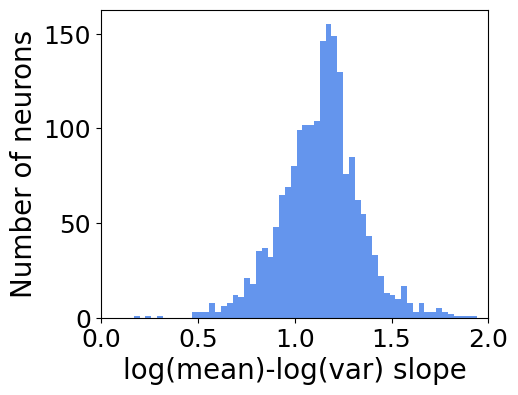

1.1497268044551792


In [20]:
# Linear Fitting Slope across trial types (ABO Neuropixels all neurons) (loglog line)

num_sess = 32

# Iterate over all sessions
list_slopes_all_att_loglog = np.empty(num_sess, dtype=object)
for sess_ind, rate in enumerate(list_rate_all):
    print(f'session index: {sess_ind}')
    
    rate = rate.sort_index(axis=1)
    stm = rate.columns.copy()

    # Multiply by delta t to convert to spike counts
    rate = rate * 0.25

    # Create a counting dictionary for each stimulus
    all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
    stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

    # Compute mean & variance for each stimulus
    rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate)
    rate_sorted_FF = rate_sorted_var.div(rate_sorted_mean)

    rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate)
    rate_sorted_FF_coll = rate_sorted_var_coll.div(rate_sorted_mean_coll)

    # Calculate and collect linear slopes for all neurons
    slopes = np.zeros((2, rate_sorted_mean_coll.shape[0]))
    for neu_ind in rate_sorted_mean_coll.index:

        # loglog scale
        bool_mean_notzero = rate_sorted_mean_coll.loc[neu_ind] > 0
        popt = np.polyfit(np.log10(rate_sorted_mean.loc[neu_ind, bool_mean_notzero].values).flatten().astype(np.float32), \
                             np.log10(rate_sorted_var.loc[neu_ind, bool_mean_notzero].values).flatten().astype(np.float32), 1)
        
        slopes[:, neu_ind] = popt.copy()
            
    list_slopes_all_att_loglog[sess_ind] = slopes.copy()

# Histogram of slopes (all sessions)
fig, ax = plt.subplots(figsize=(5, 4))

list_slopes_all_att_loglog_flattened = np.concatenate([slopes[0, :].flatten() for sess_ind, slopes in enumerate(list_slopes_all_att_loglog) if sess_ind != 0 and sess_ind != 6])
bin_size = 0.03
lower_bound, upper_bound = math.floor(np.min(list_slopes_all_att_loglog_flattened)), \
    math.ceil(np.max(list_slopes_all_att_loglog_flattened))

weights = np.ones_like(list_slopes_all_att_loglog_flattened)
# weights = np.ones_like(list_slopes_all_att_loglog_flattened) / len(list_slopes_all_att_loglog_flattened)
ax.hist(list_slopes_all_att_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
        weights=weights, color='cornflowerblue')
# plt.axvline(1, color='r', linestyle='--')

# ax.set_title('Experimental Data', fontsize=24)
ax.set_xlabel('log(mean)-log(var) slope', fontsize=20)
ax.set_ylabel('Number of neurons', fontsize=20)
# ax.set_ylabel('Frequency of neurons', fontsize=20)
ax.set_xticks([0, 0.5, 1, 1.5, 2])
# ax.set_yticks([100, 300, 500, 700])
ax.tick_params('both', labelsize=18)

ax.set_xlim(0, 2)

plt.show()
print(np.median(list_slopes_all_att_loglog_flattened))

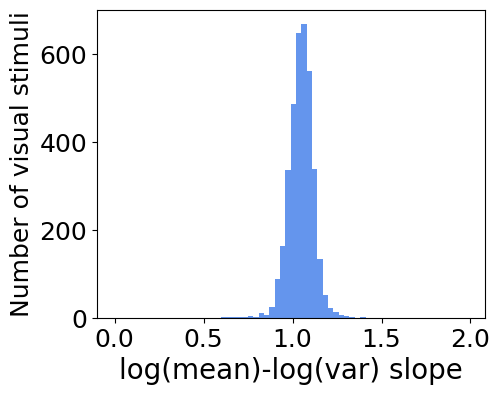

1.0507518355485015
Slope mean = 1.048282010966116, SEM = 0.0011310216545212795


In [21]:
# Linear Fitting Slope across neurons (ABO Neuropixels all neurons) (loglog line)

# # Iterate over all sessions
# list_slopes_all_an_loglog = np.empty(num_sess, dtype=object)
# for sess_ind, rate in enumerate(list_rate_all):
#     print(f'session index: {sess_ind}')
    
#     rate = rate.sort_index(axis=1)
#     stm = rate.columns.copy()

#     # Multiply by delta t to convert to spike counts
#     rate = rate * 0.25

#     # Create a counting dictionary for each stimulus
#     all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
#     stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

#     # Compute mean & variance for each stimulus
#     rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate)
#     rate_sorted_FF = rate_sorted_var.div(rate_sorted_mean)

#     rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate)

#     # Calculate and collect linear slopes for all stimuli
#     slopes = np.zeros((2, rate_sorted_mean_coll.shape[1]))
#     for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):

#         # # arithmetic scale
#         # popt = np.polyfit(rate_sorted_mean.loc[neu_ind, :].astype(np.float32), \
#         #                     rate_sorted_FF.loc[neu_ind, :].astype(np.float32), 1)
#         # slopes[ind] = popt[0]

#         # loglog scale
#         bool_mean_notzero = rate_sorted_mean_coll.loc[:, trial_type] > 0
#         popt = np.polyfit(np.log10(rate_sorted_mean.loc[bool_mean_notzero, trial_type].values).flatten().astype(np.float32), \
#                              np.log10(rate_sorted_var.loc[bool_mean_notzero, trial_type].values).flatten().astype(np.float32), 1)
#         # popt = np.polyfit(np.log10(rate_sorted_mean.loc[:, trial_type].values).flatten().astype(np.float32), \
#         #                      np.log10(rate_sorted_var.loc[:, trial_type].values).flatten().astype(np.float32), 1)
        
#         slopes[:, trial_type_ind] = popt.copy()
    
#     list_slopes_all_an_loglog[sess_ind] = slopes.copy()

# Histogram of slopes (all sessions)
fig, ax = plt.subplots(figsize=(5, 4))

list_slopes_all_an_loglog_flattened = np.concatenate([slopes[0, :].flatten() for sess_ind, slopes in enumerate(list_slopes_all_an_loglog) if sess_ind != 0 and sess_ind != 6])
bin_size = 0.03
lower_bound, upper_bound = math.floor(np.min(list_slopes_all_an_loglog_flattened)), \
    math.ceil(np.max(list_slopes_all_an_loglog_flattened))

weights = np.ones_like(list_slopes_all_an_loglog_flattened)
# weights = np.ones_like(list_slopes_all_an_loglog_flattened) / len(list_slopes_all_an_loglog_flattened)
ax.hist(list_slopes_all_an_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
        weights=weights, color='cornflowerblue')
# plt.axvline(1, color='r', linestyle='--')

# ax.set_title('Experimental Data', fontsize=24)
ax.set_xlabel('log(mean)-log(var) slope', fontsize=20)
ax.set_ylabel('Number of visual stimuli', fontsize=18)
# ax.set_ylabel('Frequency of visual stimuli', fontsize=17)
ax.set_xticks([0, 0.5, 1, 1.5, 2])
# ax.set_yticks([100, 300, 500, 700])
ax.tick_params('both', labelsize=18)

# ax.set_xlim(0, 2)

plt.show()
print(np.median(list_slopes_all_an_loglog_flattened))
print(f'Slope mean = {np.mean(list_slopes_all_an_loglog_flattened)}, SEM = {sem(list_slopes_all_an_loglog_flattened)}')

## Figure 1B left, S1C

across trial types Mean 1.13, Std 0.21
across neurons Mean 1.05, Std 0.07


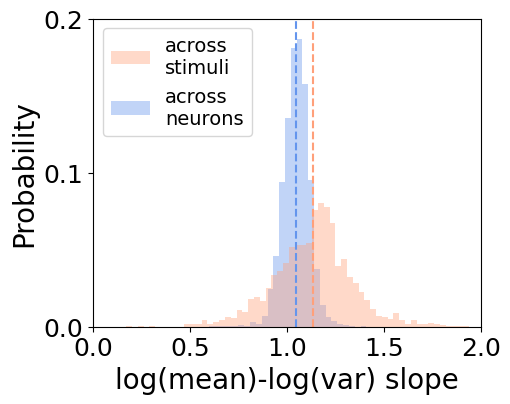

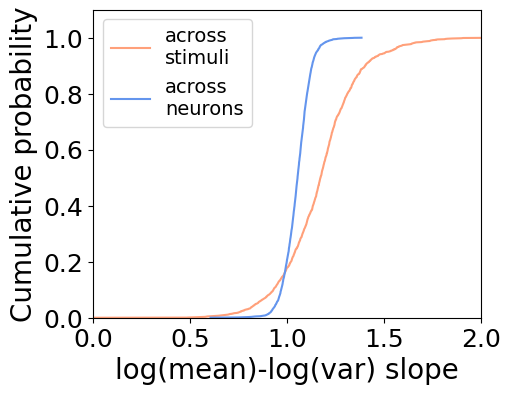

In [22]:
# loglog linear slope across trial types vs. across neurons

# 1. histogram
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# across trial types
bin_size = 0.03
lower_bound, upper_bound = math.floor(np.min(list_slopes_all_att_loglog_flattened)), \
    math.ceil(np.max(list_slopes_all_att_loglog_flattened))

# weights = np.ones_like(list_slopes_all_att_loglog_flattened)
weights = np.ones_like(list_slopes_all_att_loglog_flattened) / len(list_slopes_all_att_loglog_flattened)
ax.hist(list_slopes_all_att_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
        weights=weights, color='lightsalmon', alpha=0.4, label='across\nstimuli', zorder=2)
ax.axvline(np.nanmean(list_slopes_all_att_loglog_flattened), color='lightsalmon', linestyle='--')
print(f'across trial types Mean {np.nanmean(list_slopes_all_att_loglog_flattened):.2f}, Std {np.std(list_slopes_all_att_loglog_flattened, ddof=1):.2f}')

# across neurons
bin_size = 0.03
lower_bound, upper_bound = math.floor(np.min(list_slopes_all_an_loglog_flattened)), \
    math.ceil(np.max(list_slopes_all_an_loglog_flattened))

# weights = np.ones_like(list_slopes_all_an_loglog_flattened)
weights = np.ones_like(list_slopes_all_an_loglog_flattened) / len(list_slopes_all_an_loglog_flattened)
ax.hist(list_slopes_all_an_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
        weights=weights, color='cornflowerblue', alpha=0.4, label='across\nneurons', zorder=1)
ax.axvline(np.nanmean(list_slopes_all_an_loglog_flattened), color='cornflowerblue', linestyle='--')
print(f'across neurons Mean {np.nanmean(list_slopes_all_an_loglog_flattened):.2f}, Std {np.std(list_slopes_all_an_loglog_flattened, ddof=1):.2f}')

ax.set_xlabel('log(mean)-log(var) slope', fontsize=20)
ax.set_ylabel('Number', fontsize=18)
ax.set_ylabel('Probability', fontsize=20)
ax.set_xticks([0, 0.5, 1, 1.5, 2])
ax.set_yticks(np.arange(0, 0.21, 0.1))
ax.tick_params('both', labelsize=18)

ax.legend(loc='upper left', prop={'size': 14})
ax.set_xlim(0, 2)

plt.savefig('..\\..\\code_images\\neural_variability_robustness\\slope_histogram_asis_2cond.svg', bbox_inches='tight')
plt.show()

# 2. cumulative distribution function
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

cdf_acrtt = np.cumsum(sorted(list_slopes_all_att_loglog_flattened))
ax.plot(sorted(list_slopes_all_att_loglog_flattened), cdf_acrtt/cdf_acrtt[-1], color='lightsalmon', label='across\nstimuli')

cdf_acrneu = np.cumsum(sorted(list_slopes_all_an_loglog_flattened))
ax.plot(sorted(list_slopes_all_an_loglog_flattened), cdf_acrneu/cdf_acrneu[-1], color='cornflowerblue', label='across\nneurons')

ax.set_xlabel('log(mean)-log(var) slope', fontsize=20)
ax.set_ylabel('Cumulative probability', fontsize=20)
ax.tick_params('both', labelsize=18)

ax.set_xlim(0, 2)
ax.set_ylim(0, 1.1)
ax.legend(loc='upper left', prop={'size': 14})

plt.show()

## Figure S1E

test statistic = 4675114.00
p = 0.0000


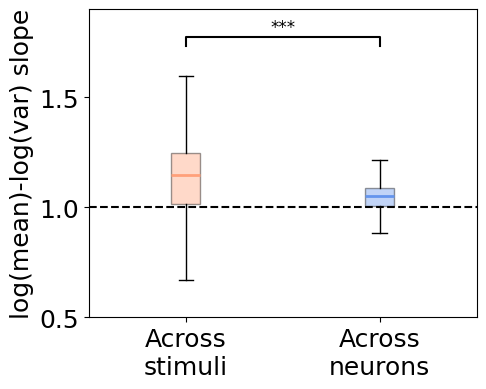

In [23]:
# # loglog linear slope across trial types vs. across neurons (boxplot)

num_sess = 32

fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes = np.array(axes).flatten()

# Wilcoxon ranksum test
stat, pval = mannwhitneyu(list_slopes_all_att_loglog_flattened, list_slopes_all_an_loglog_flattened)
print(f'test statistic = {stat:.2f}\np = {pval:.4f}')

# boxplot
box = axes[0].boxplot([list_slopes_all_att_loglog_flattened, list_slopes_all_an_loglog_flattened],
                      showfliers=False, patch_artist=True)
axes[0].axhline(1, color='k', linestyle='--')

# Set colors
# for patch in box['boxes']:
#     patch.set(facecolor='w') # box color
box['boxes'][0].set(facecolor='lightsalmon', alpha=0.4) # box color
box['boxes'][1].set(facecolor='cornflowerblue', alpha=0.4)
box['medians'][0].set(color='lightsalmon', linewidth=2) # median line color
box['medians'][1].set(color='cornflowerblue', linewidth=2)

axes[0].set_xticklabels(['Across\nstimuli', 'Across\nneurons'])
axes[0].set_ylabel('log(mean)-log(var) slope', fontsize=18)
axes[0].tick_params('both', labelsize=18)

axes[0].set_ylim(0.5, 1.9)
axes[0].set_yticks(np.arange(0.5, 2, 0.5))

# significance
barplot_annotate_brackets(0, 1, pval, center=[1, 2],
                          height=[axes[0].get_ylim()[1]*0.78]*2, dh=.18, barh=.03,
                          axes=axes, ax_ind=0, fs=12)

# axes[0].legend(prop={'size': 12})

plt.show()

session index: 0
session index: 1
session index: 2
session index: 3
session index: 4
session index: 5
session index: 6
session index: 7
session index: 8
session index: 9
session index: 10
session index: 11
session index: 12
session index: 13
session index: 14
session index: 15
session index: 16
session index: 17
session index: 18
session index: 19
session index: 20
session index: 21
session index: 22
session index: 23
session index: 24
session index: 25
session index: 26
session index: 27
session index: 28
session index: 29
session index: 30
session index: 31


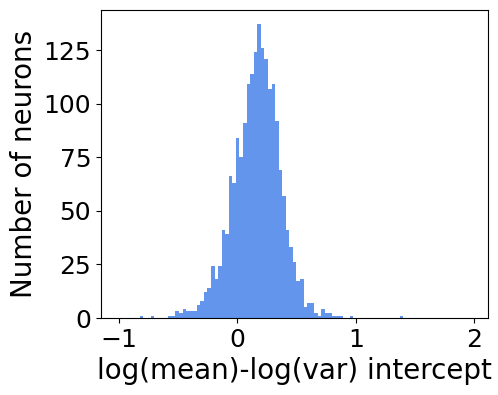

0.17572301234076143


In [23]:
# Linear Fitting Intercept across trial types (ABO Neuropixels all neurons) (loglog line)

num_sess = 32

# Iterate over all sessions
list_slopes_all_att_loglog = np.empty(num_sess, dtype=object)
for sess_ind, rate in enumerate(list_rate_all):
    print(f'session index: {sess_ind}')
    
    rate = rate.sort_index(axis=1)
    stm = rate.columns.copy()

    # Multiply by delta t to convert to spike counts
    rate = rate * 0.25

    # Create a counting dictionary for each stimulus
    all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
    stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

    # Compute mean & variance for each stimulus
    rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate)
    rate_sorted_FF = rate_sorted_var.div(rate_sorted_mean)

    rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate)
    rate_sorted_FF_coll = rate_sorted_var_coll.div(rate_sorted_mean_coll)

    # Calculate and collect linear slopes for all neurons
    slopes = np.zeros((2, rate_sorted_mean_coll.shape[0]))
    for neu_ind in rate_sorted_mean_coll.index:

        # loglog scale
        bool_mean_notzero = rate_sorted_mean_coll.loc[neu_ind] > 0
        popt = np.polyfit(np.log10(rate_sorted_mean.loc[neu_ind, bool_mean_notzero].values).flatten().astype(np.float32), \
                             np.log10(rate_sorted_var.loc[neu_ind, bool_mean_notzero].values).flatten().astype(np.float32), 1)
        
        slopes[:, neu_ind] = popt.copy()
            
    list_slopes_all_att_loglog[sess_ind] = slopes.copy()

# Histogram of slopes (all sessions)
fig, ax = plt.subplots(figsize=(5, 4))

list_intcpt_all_att_loglog_flattened = np.concatenate([slopes[1, :].flatten() for sess_ind, slopes in enumerate(list_slopes_all_att_loglog) if sess_ind != 0 and sess_ind != 6])
bin_size = 0.03
lower_bound, upper_bound = math.floor(np.min(list_intcpt_all_att_loglog_flattened)), \
    math.ceil(np.max(list_intcpt_all_att_loglog_flattened))

weights = np.ones_like(list_intcpt_all_att_loglog_flattened)
# weights = np.ones_like(list_intcpt_all_att_loglog_flattened) / len(list_intcpt_all_att_loglog_flattened)
ax.hist(list_intcpt_all_att_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
        weights=weights, color='cornflowerblue')
# plt.axvline(1, color='r', linestyle='--')

# ax.set_title('Experimental Data', fontsize=24)
ax.set_xlabel('log(mean)-log(var) intercept', fontsize=20)
ax.set_ylabel('Number of neurons', fontsize=20)
# ax.set_ylabel('Frequency of neurons', fontsize=20)
# ax.set_xticks([0, 0.5, 1, 1.5, 2])
# ax.set_yticks([100, 300, 500, 700])
ax.tick_params('both', labelsize=18)

# ax.set_xlim(0, 2)

plt.show()
print(np.median(list_intcpt_all_att_loglog_flattened))

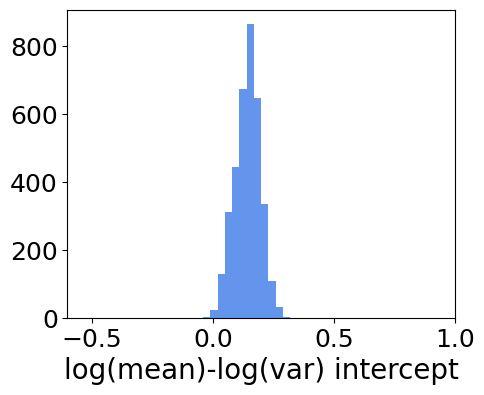

0.14730789869675595


In [24]:
# Linear Fitting Intercept across neurons (ABO Neuropixels all neurons) (loglog line)

# # Iterate over all sessions
# list_slopes_all_an_loglog = np.empty(num_sess, dtype=object)
# for sess_ind, rate in enumerate(list_rate_all):
#     print(f'session index: {sess_ind}')
    
#     rate = rate.sort_index(axis=1)
#     stm = rate.columns.copy()

#     # Multiply by delta t to convert to spike counts
#     rate = rate * 0.25

#     # Create a counting dictionary for each stimulus
#     all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
#     stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

#     # Compute mean & variance for each stimulus
#     rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate)
#     rate_sorted_FF = rate_sorted_var.div(rate_sorted_mean)

#     rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate)

#     # Calculate and collect linear slopes for all stimuli
#     slopes = np.zeros((2, rate_sorted_mean_coll.shape[1]))
#     for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):

#         # # arithmetic scale
#         # popt = np.polyfit(rate_sorted_mean.loc[neu_ind, :].astype(np.float32), \
#         #                     rate_sorted_FF.loc[neu_ind, :].astype(np.float32), 1)
#         # slopes[ind] = popt[0]

#         # loglog scale
#         bool_mean_notzero = rate_sorted_mean_coll.loc[:, trial_type] > 0
#         popt = np.polyfit(np.log10(rate_sorted_mean.loc[bool_mean_notzero, trial_type].values).flatten().astype(np.float32), \
#                              np.log10(rate_sorted_var.loc[bool_mean_notzero, trial_type].values).flatten().astype(np.float32), 1)
#         # popt = np.polyfit(np.log10(rate_sorted_mean.loc[:, trial_type].values).flatten().astype(np.float32), \
#         #                      np.log10(rate_sorted_var.loc[:, trial_type].values).flatten().astype(np.float32), 1)
        
#         slopes[:, trial_type_ind] = popt.copy()
    
#     list_slopes_all_an_loglog[sess_ind] = slopes.copy()

# Histogram of slopes (all sessions)
fig, ax = plt.subplots(figsize=(5, 4))

list_intcpt_all_an_loglog_flattened = np.concatenate([slopes[1, :].flatten() for sess_ind, slopes in enumerate(list_slopes_all_an_loglog) if sess_ind != 0 and sess_ind != 6])
bin_size = 0.03
lower_bound, upper_bound = math.floor(np.min(list_intcpt_all_an_loglog_flattened)), \
    math.ceil(np.max(list_intcpt_all_an_loglog_flattened))

ax.hist(list_intcpt_all_an_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
        color='cornflowerblue')
# plt.axvline(1, color='r', linestyle='--')

# ax.set_title('Experimental Data', fontsize=24)
ax.set_xlabel('log(mean)-log(var) intercept', fontsize=20)
# ax.set_ylabel('Number of stimuli', fontsize=20)
ax.set_xlim([-0.6, 1])
ax.set_xticks([-0.5, 0, 0.5, 1])
# ax.set_yticks([100, 300, 500, 700])
ax.tick_params('both', labelsize=18)

plt.show()
print(np.median(list_intcpt_all_an_loglog_flattened))

## Figure 1B right

across trial types Mean 0.17, Std 0.20
across neurons Mean 0.14, Std 0.05


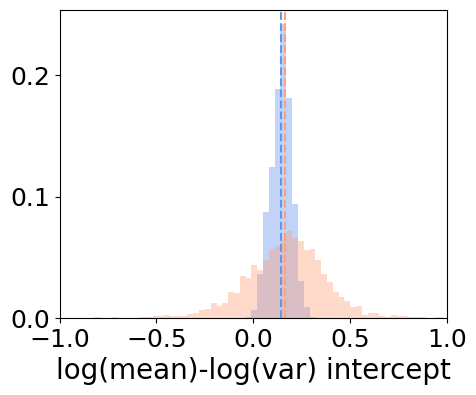

In [25]:
# loglog linear intercept across trial types vs. across neurons

# 1. histogram
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# across trial types
bin_size = 0.03
lower_bound, upper_bound = math.floor(np.min(list_intcpt_all_att_loglog_flattened)), \
    math.ceil(np.max(list_intcpt_all_att_loglog_flattened))

# weights = np.ones_like(list_intcpt_all_att_loglog_flattened)
weights = np.ones_like(list_intcpt_all_att_loglog_flattened) / len(list_intcpt_all_att_loglog_flattened)
ax.hist(list_intcpt_all_att_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
        weights=weights, color='lightsalmon', alpha=0.4, label='across\nstimuli', zorder=2)
ax.axvline(np.nanmean(list_intcpt_all_att_loglog_flattened), color='lightsalmon', linestyle='--')
print(f'across trial types Mean {np.nanmean(list_intcpt_all_att_loglog_flattened):.2f}, Std {np.std(list_intcpt_all_att_loglog_flattened, ddof=1):.2f}')

# across neurons
bin_size = 0.03
lower_bound, upper_bound = math.floor(np.min(list_intcpt_all_an_loglog_flattened)), \
    math.ceil(np.max(list_intcpt_all_an_loglog_flattened))

# weights = np.ones_like(list_intcpt_all_an_loglog_flattened)
weights = np.ones_like(list_intcpt_all_an_loglog_flattened) / len(list_intcpt_all_an_loglog_flattened)
ax.hist(list_intcpt_all_an_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
        weights=weights, color='cornflowerblue', alpha=0.4, label='across\nneurons', zorder=1)
ax.axvline(np.nanmean(list_intcpt_all_an_loglog_flattened), color='cornflowerblue', linestyle='--')
print(f'across neurons Mean {np.nanmean(list_intcpt_all_an_loglog_flattened):.2f}, Std {np.std(list_intcpt_all_an_loglog_flattened, ddof=1):.2f}')

ax.set_xlabel('log(mean)-log(var) intercept', fontsize=20)
# ax.set_ylabel('Number', fontsize=18)
# ax.set_ylabel('Probability', fontsize=20)
# ax.set_xticks([0, 0.5, 1, 1.5, 2])
ax.set_yticks(np.arange(0, 0.25, 0.1))
ax.tick_params('both', labelsize=18)

# # ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), prop={'size': 14})
# ax.legend(loc='upper left', prop={'size': 14})
ax.set_xlim(-1, 1)

plt.savefig('..\\..\\code_images\\neural_variability_robustness\\intcpt_histogram_asis_2cond.svg', bbox_inches='tight')
plt.show()

In [27]:
# # Collect modulated poisson parameters for each session (across stimuli, fit to each stimulus)

# num_sess = 32

# list_var_G_estim_neu2 = np.empty(num_sess, dtype=object)
# list_mu_estim_neu2 = np.empty(num_sess, dtype=object)
# list_sample_mean = np.empty(num_sess, dtype=object)

# for sess_ind in range(num_sess):
#     file_name = 'poisson_fit_rs_sep_ABO_' + str(sess_ind) + '.pickle'
    
#     with open(file_name, 'rb') as f:
#         poisson_fit_rs_sep_ABO = pickle.load(f)

#         list_var_G_estim_neu2[sess_ind] = poisson_fit_rs_sep_ABO['list_var_G_estim_neu'].copy()
#         list_mu_estim_neu2[sess_ind] = poisson_fit_rs_sep_ABO['list_mu_estim_neu'].copy()
#         list_sample_mean[sess_ind] = poisson_fit_rs_sep_ABO['sample_mean'].copy()

# save_file_name = 'poisson_fit_rs_sep_ABO_all.pickle'
# # save_file_name = os.path.join('..', 'data', save_file_name)
# with open(save_file_name, 'wb') as f:
#     pickle.dump({'tree_variables': ['list_var_G_estim_neu2', 'list_mu_estim_neu2', 'list_sample_mean'],
#                     'list_var_G_estim_neu2': list_var_G_estim_neu2, 'list_mu_estim_neu2': list_mu_estim_neu2, 'list_sample_mean': list_sample_mean}, f) 

In [7]:
# modulated poisson
    
save_file_name = 'poisson_fit_rs_sep_ABO_all.pickle'
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    poisson_fit_rs_sep_ABO_all = pickle.load(f)

    list_var_G_estim_neu2 = dc(poisson_fit_rs_sep_ABO_all['list_var_G_estim_neu2'])
    list_mu_estim_neu2 = dc(poisson_fit_rs_sep_ABO_all['list_mu_estim_neu2'])

# Scatterplot & Model Lines (ABO Neuropixels all neurons)

print('Mean vs. Variance (ABO Neuropixels)\n')

# Iterate over all sessions
num_sess = 32
num_trial_types = 119
list_valid_neu_inds = np.empty(num_sess, dtype=object) # indices for neurons having enough supralinearity
for sess_ind, rate in enumerate(list_rate_all):
    print(f'session index: {sess_ind}')
    
    rate_sorted = rate.sort_index(axis=1)
    stm = rate_sorted.columns.copy()

    # Multiply by delta t to convert to spike counts
    rate_sorted = rate_sorted * 0.25
    print(rate_sorted.shape[0])

    # Create a counting dictionary for each stimulus
    all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
    stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

    # Compute mean & variance for each stimulus
    rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate_sorted)
    rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate_sorted)

    list_valid_neu_inds[sess_ind] = np.where((np.sum(rate_sorted_mean_coll > rate_sorted_var_coll, axis=1) / num_trial_types) <= 0.5)[0]

Mean vs. Variance (ABO Neuropixels)

session index: 0
60
session index: 1
52
session index: 2
41
session index: 3
110
session index: 4
40
session index: 5
19
session index: 6
33
session index: 7
45
session index: 8
35
session index: 9
14
session index: 10
63
session index: 11
52
session index: 12
49
session index: 13
102
session index: 14
92
session index: 15
75
session index: 16
51
session index: 17
85
session index: 18
80
session index: 19
47
session index: 20
58
session index: 21
72
session index: 22
88
session index: 23
36
session index: 24
84
session index: 25
75
session index: 26
73
session index: 27
37
session index: 28
93
session index: 29
85
session index: 30
94
session index: 31
75


In [8]:
# modulated poisson across neurons

save_file_name = 'poisson_fit_rs_sep_ABO_all.pickle'
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    poisson_fit_rs_sep_ABO_all = pickle.load(f)

    list_var_G_estim_neu2 = dc(poisson_fit_rs_sep_ABO_all['list_var_G_estim_neu2'])
    list_mu_estim_neu2 = dc(poisson_fit_rs_sep_ABO_all['list_mu_estim_neu2'])

# Scatterplot & Model Lines (ABO Neuropixels all neurons)

print('Mean vs. Variance (ABO Neuropixels)\n')

list_valid_tt_inds = np.empty(num_sess, dtype=object)

# Iterate over all sessions
for sess_ind, rate in enumerate(list_rate_all):
    print(f'session index: {sess_ind}')
    
    rate_sorted = rate.sort_index(axis=1)
    stm = rate_sorted.columns.copy()

    # Multiply by delta t to convert to spike counts
    rate_sorted = rate_sorted * 0.25
    print(rate_sorted.shape[0])

    # Create a counting dictionary for each stimulus
    all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
    stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

    # Compute mean & variance for each stimulus
    rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate_sorted)
    rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate_sorted)

    list_valid_tt_inds[sess_ind] = np.where((np.sum(rate_sorted_mean_coll > rate_sorted_var_coll, axis=0) / rate_sorted_mean_coll.shape[0]) <= 0.5)[0]

Mean vs. Variance (ABO Neuropixels)

session index: 0
60
session index: 1
52
session index: 2
41
session index: 3
110
session index: 4
40
session index: 5
19
session index: 6
33
session index: 7
45
session index: 8
35
session index: 9
14
session index: 10
63
session index: 11
52
session index: 12
49
session index: 13
102
session index: 14
92
session index: 15
75
session index: 16
51
session index: 17
85
session index: 18
80
session index: 19
47
session index: 20
58
session index: 21
72
session index: 22
88
session index: 23
36
session index: 24
84
session index: 25
75
session index: 26
73
session index: 27
37
session index: 28
93
session index: 29
85
session index: 30
94
session index: 31
75


## Figure S1B, S1D

mean: 0.7751896141827849
std: 0.9223303414551388
median: 0.48264286290476066
mean: 0.2590506360340204
std: 0.15243979389327703
median: 0.24489273881571927


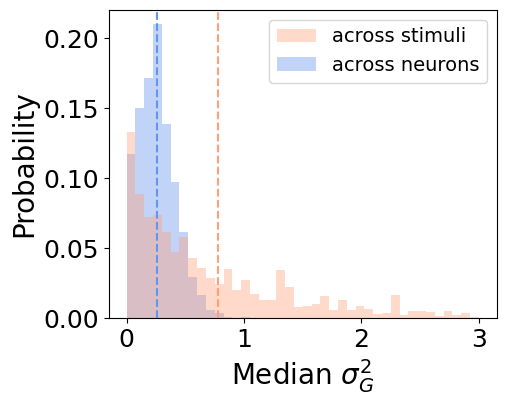

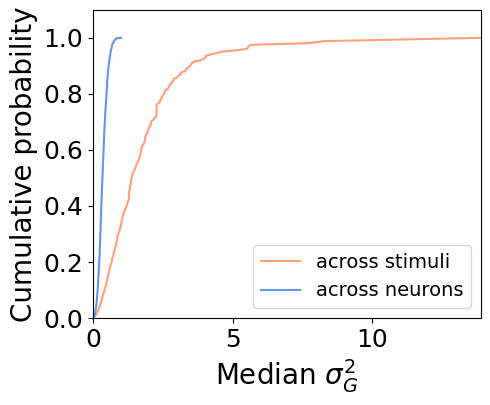

In [9]:
# Compare modulated poisson sigma G (across stimuli vs. across neurons) (fit to each stimulus)

save_file_name = 'poisson_fit_rs_sep_ABO_all.pickle'
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    poisson_fit_rs_sep_ABO_all = pickle.load(f)

    list_var_G_estim_neu2 = dc(poisson_fit_rs_sep_ABO_all['list_var_G_estim_neu2'])
    list_mu_estim_neu2 = dc(poisson_fit_rs_sep_ABO_all['list_mu_estim_neu2'])

num_sess = 32

# 1. histogram
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# across stimuli
list_var_G_estim_acrtt = np.zeros(0)
for sess_ind in range(num_sess):
    if sess_ind != 0 and sess_ind != 6:
        valid_neu_inds = list_valid_neu_inds[sess_ind].copy()
        # print(f'session {sess_ind} % valid neurons = {valid_neu_inds.shape[0] / list_var_G_estim_neu2[sess_ind].shape[0]:.2f}')
        list_var_G_estim_acrtt = np.concatenate([list_var_G_estim_acrtt, np.nanmedian(list_var_G_estim_neu2[sess_ind][valid_neu_inds], axis=1)]) 

# print(list_var_G_estim_acrtt.shape) # number of total neurons across all sessions

weights = np.ones_like(list_var_G_estim_acrtt) / list_var_G_estim_acrtt.shape[0]
ax.hist(list_var_G_estim_acrtt, bins=40, range=(0, 3), weights=weights, color='lightsalmon', alpha=0.4, label='across stimuli', zorder=2)
ax.axvline(np.nanmean(list_var_G_estim_acrtt), color='lightsalmon', linestyle='--')

print(f'mean: {np.nanmean(list_var_G_estim_acrtt)}\nstd: {np.nanstd(list_var_G_estim_acrtt, ddof=1)}\nmedian: {np.nanmedian(list_var_G_estim_acrtt)}')

# plt.show()

# across neurons
list_var_G_estim_acrneu = np.zeros(0)
for sess_ind in range(num_sess):
    if sess_ind != 0 and sess_ind != 6:
        valid_tt_inds = list_valid_tt_inds[sess_ind].copy()
        list_var_G_estim_acrneu = np.concatenate([list_var_G_estim_acrneu, np.nanmedian(list_var_G_estim_neu2[sess_ind][:, valid_tt_inds], axis=0)])

# print(list_var_G_estim_acrneu.shape) # num_trial_types x num_sessions

weights = np.ones_like(list_var_G_estim_acrneu) / list_var_G_estim_acrneu.shape[0]
ax.hist(list_var_G_estim_acrneu, bins=40, range=(0, 3), weights=weights, color='cornflowerblue', alpha=0.4, label='across neurons', zorder=1)
ax.axvline(np.nanmean(list_var_G_estim_acrneu), color='cornflowerblue', linestyle='--')

ax.set_xlabel('Median $\sigma_G^2$', fontsize=20)
ax.set_ylabel('Probability', fontsize=20)
ax.tick_params('both', labelsize=18)

ax.legend(prop={'size': 14})

print(f'mean: {np.nanmean(list_var_G_estim_acrneu)}\nstd: {np.nanstd(list_var_G_estim_acrneu, ddof=1)}\nmedian: {np.nanmedian(list_var_G_estim_acrneu)}')

plt.show()

# 2. cumulative distribution function
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

cdf_acrtt = np.cumsum(sorted(list_var_G_estim_acrtt))
ax.plot(sorted(list_var_G_estim_acrtt), cdf_acrtt/cdf_acrtt[-1], color='lightsalmon', label='across stimuli')

cdf_acrneu = np.cumsum(sorted(list_var_G_estim_acrneu))
ax.plot(sorted(list_var_G_estim_acrneu), cdf_acrneu/cdf_acrneu[-1], color='cornflowerblue', label='across neurons')

ax.set_xlabel('Median $\sigma_G^2$', fontsize=20)
ax.set_ylabel('Cumulative probability', fontsize=20)
ax.tick_params('both', labelsize=18)

ax.set_xlim(0, np.max(list_var_G_estim_acrtt))
ax.set_ylim(0, 1.1)
ax.legend(prop={'size': 14})

plt.show()

## Figure S1F

mean: 0.7751896141827849
std: 0.9223303414551388
median: 0.48264286290476066
mean: 0.2590506360340204
std: 0.15243979389327703
median: 0.24489273881571927
test statistic = 3693914.50
p = 0.0000


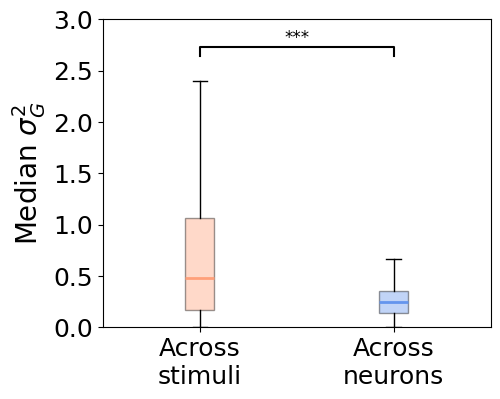

In [10]:
# Compare modulated poisson sigma G (across stimuli vs. across neurons) (fit to each stimulus) (boxplot)

save_file_name = 'poisson_fit_rs_sep_ABO_all.pickle'
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    poisson_fit_rs_sep_ABO_all = pickle.load(f)

    list_var_G_estim_neu2 = dc(poisson_fit_rs_sep_ABO_all['list_var_G_estim_neu2'])
    list_mu_estim_neu2 = dc(poisson_fit_rs_sep_ABO_all['list_mu_estim_neu2'])

num_sess = 32

fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes = np.array(axes).flatten()

# across stimuli
list_var_G_estim_acrtt = np.zeros(0)
for sess_ind in range(num_sess):
    if sess_ind != 0 and sess_ind != 6:
        valid_neu_inds = list_valid_neu_inds[sess_ind].copy()
        # print(f'session {sess_ind} % valid neurons = {valid_neu_inds.shape[0] / list_var_G_estim_neu2[sess_ind].shape[0]:.2f}')
        list_var_G_estim_acrtt = np.concatenate([list_var_G_estim_acrtt, np.nanmedian(list_var_G_estim_neu2[sess_ind][valid_neu_inds], axis=1)]) 

# print(list_var_G_estim_acrtt.shape) # number of total neurons across all sessions

print(f'mean: {np.nanmean(list_var_G_estim_acrtt)}\nstd: {np.nanstd(list_var_G_estim_acrtt, ddof=1)}\nmedian: {np.nanmedian(list_var_G_estim_acrtt)}')

# plt.show()

# across neurons
list_var_G_estim_acrneu = np.zeros(0)
for sess_ind in range(num_sess):
    if sess_ind != 0 and sess_ind != 6:
        valid_tt_inds = list_valid_tt_inds[sess_ind].copy()
        list_var_G_estim_acrneu = np.concatenate([list_var_G_estim_acrneu, np.nanmedian(list_var_G_estim_neu2[sess_ind][:, valid_tt_inds], axis=0)])

# print(list_var_G_estim_acrneu.shape) # num_trial_types x num_sessions

print(f'mean: {np.nanmean(list_var_G_estim_acrneu)}\nstd: {np.nanstd(list_var_G_estim_acrneu, ddof=1)}\nmedian: {np.nanmedian(list_var_G_estim_acrneu)}')

# Wilcoxon ranksum test
stat, pval = mannwhitneyu(list_var_G_estim_acrtt, list_var_G_estim_acrneu)
print(f'test statistic = {stat:.2f}\np = {pval:.4f}')

# boxplot
box = axes[0].boxplot([list_var_G_estim_acrtt, list_var_G_estim_acrneu], showfliers=False, patch_artist=True)

# Set colors
# for patch in box['boxes']:
#     patch.set(facecolor='w') # box color
box['boxes'][0].set(facecolor='lightsalmon', alpha=0.4) # box color
box['boxes'][1].set(facecolor='cornflowerblue', alpha=0.4)
box['medians'][0].set(color='lightsalmon', linewidth=2) # median line color
box['medians'][1].set(color='cornflowerblue', linewidth=2)

axes[0].set_xticklabels(['Across\nstimuli', 'Across\nneurons'])
axes[0].set_ylabel('Median $\sigma_G^2$', fontsize=20)
axes[0].tick_params('both', labelsize=18)

axes[0].set_ylim(0, 3)

# significance
barplot_annotate_brackets(0, 1, pval, center=[1, 2],
                          height=[axes[0].get_ylim()[1]*0.7]*2, dh=.18, barh=.03,
                          axes=axes, ax_ind=0, fs=12)

# axes[0].legend(prop={'size': 12})

plt.show()

In [32]:
with open('resp_matrix_ep_HVA_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_HVA_allensdk = pickle.load(f)

    list_rate_all_HVA = dc(resp_matrix_ep_HVA_allensdk['list_rate_all_HVA'])
    list_slopes_all_an_loglog_HVA = dc(resp_matrix_ep_HVA_allensdk['list_slopes_all_an_loglog_HVA'])

# Iterate over all visual areas (V1 + 5 HVAs)

num_sess = 32

list_vis_areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']
list_HVA_names = ['VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']
list_lowq_sess_HVA = {hva: np.full(num_sess, np.nan) for hva in list_HVA_names}
for area_ind, area in enumerate(list_HVA_names):

    # Iterate over all sessions
    for sess_ind in range(num_sess):
        # print(f'session index: {sess_ind}')
            
        rate = list_rate_all_HVA[area][sess_ind].copy()
        
        if np.any(rate) == True: # if neurons exist
            rate = rate.sort_index(axis=1)
            stm = rate.columns.copy()

            # Multiply by delta t to convert to spike counts
            rate = rate * 0.25

            list_lowq_sess_HVA[area][sess_ind] = np.all(rate == 0, axis=0).sum() / rate.shape[1]

## Figure S3B

VISp slope median = 1.05


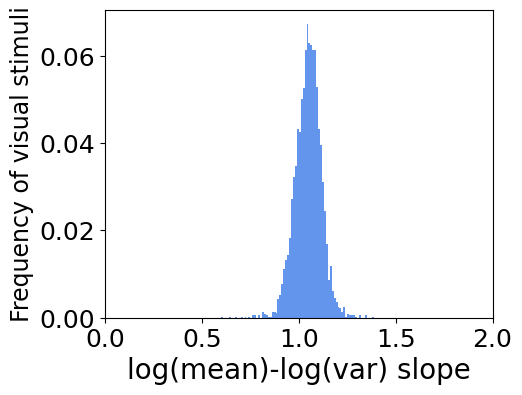

VISl slope median = 1.06


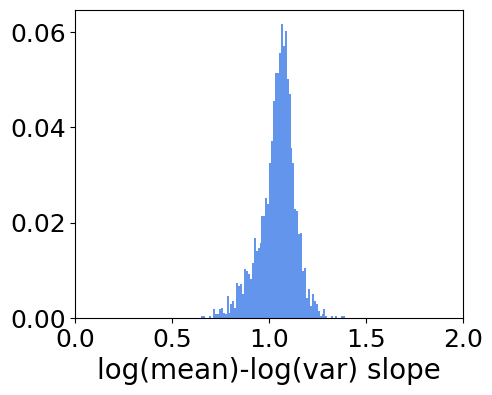

VISrl slope median = 1.04


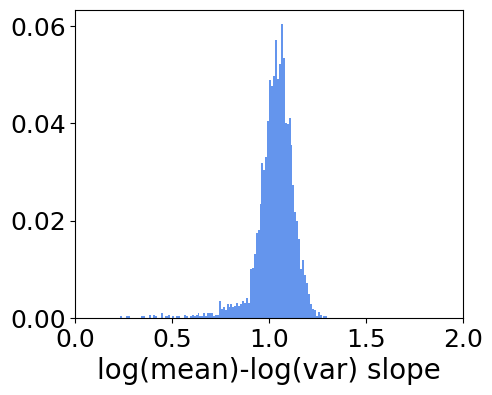

VISal slope median = 1.04


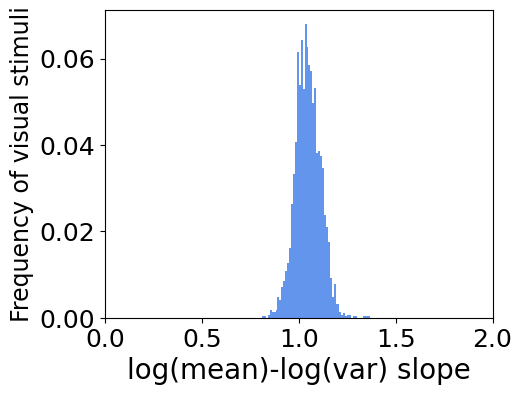

VISpm slope median = 1.00


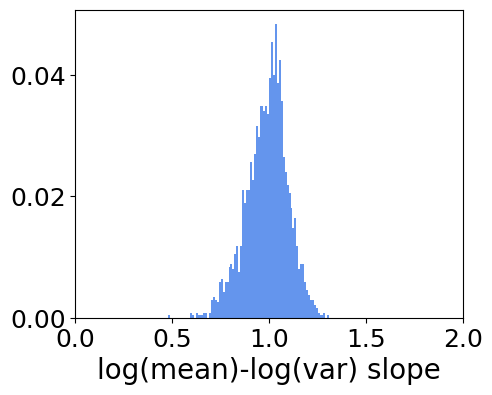

VISam slope median = 1.02


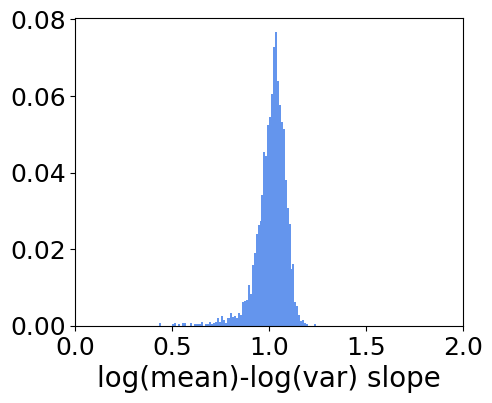

In [ ]:
# Linear Fitting Slope across neurons (ABO Neuropixels all neurons) (loglog line)

with open('resp_matrix_ep_HVA_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_HVA_allensdk = pickle.load(f)

    list_rate_all_HVA = dc(resp_matrix_ep_HVA_allensdk['list_rate_all_HVA'])
    list_slopes_all_an_loglog_HVA = dc(resp_matrix_ep_HVA_allensdk['list_slopes_all_an_loglog_HVA'])
    list_slopes_flattened2_HVA = dc(resp_matrix_ep_HVA_allensdk['list_slopes_flattened2'])

with open('resp_matrix_ep_RS_all_32sess_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_RS_all = pickle.load(f)

    list_rate_all = resp_matrix_ep_RS_all['list_rate_all'].copy()
    list_slopes_all_an_loglog = resp_matrix_ep_RS_all['list_slopes_all_an_loglog'].copy()

# Iterate over all visual areas (V1 + 5 HVAs)

num_sess = 32

list_vis_areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']
list_HVA_names = ['VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']
# list_slopes_flattened2_HVA = np.empty(len(list_vis_areas), dtype=object)
# list_slopes_all_an_loglog_HVA = {hva: 0 for hva in list_HVA_names}
for area_ind, area in enumerate(list_vis_areas):

    fig, axes = plt.subplots(1, 1, figsize=(5, 4))
    axes = np.array(axes).flatten()

    # # Iterate over all sessions
    # list_slopes_all_an_loglog = np.empty(num_sess, dtype=object)
    # for sess_ind in range(num_sess):
    #     print(f'session index: {sess_ind}')

    #     if area_ind == 0:
    #         rate = list_rate_all[sess_ind].copy()
    #     else:
    #         rate = list_rate_all_HVA[area][sess_ind].copy()
        
    #     if np.any(rate) == True: # if neurons exist
    #         rate = rate.sort_index(axis=1)
    #         stm = rate.columns.copy()

    #         # Multiply by delta t to convert to spike counts
    #         rate = rate * 0.25

    #         # Create a counting dictionary for each stimulus
    #         all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
    #         stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

    #         # Compute mean & variance for each stimulus
    #         rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate)
    #         rate_sorted_FF = rate_sorted_var.div(rate_sorted_mean)

    #         rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate)

    #         # Calculate and collect linear slopes for all stimuli
    #         slopes = np.zeros((2, rate_sorted_mean_coll.shape[1]))
    #         for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):

    #             # # arithmetic scale
    #             # popt = np.polyfit(rate_sorted_mean.loc[neu_ind, :].astype(np.float32), \
    #             #                     rate_sorted_FF.loc[neu_ind, :].astype(np.float32), 1)
    #             # slopes[ind] = popt[0]

    #             # loglog scale
    #             bool_mean_notzero = rate_sorted_mean_coll.loc[:, trial_type] > 0
    #             popt = np.polyfit(np.log10(rate_sorted_mean.loc[bool_mean_notzero, trial_type].values).flatten().astype(np.float32), \
    #                                 np.log10(rate_sorted_var.loc[bool_mean_notzero, trial_type].values).flatten().astype(np.float32), 1)
    #             # popt = np.polyfit(np.log10(rate_sorted_mean.loc[:, trial_type].values).flatten().astype(np.float32), \
    #             #                      np.log10(rate_sorted_var.loc[:, trial_type].values).flatten().astype(np.float32), 1)
                
    #             slopes[:, trial_type_ind] = popt.copy()
            
    #         list_slopes_all_an_loglog[sess_ind] = slopes.copy()

    # Histogram of slopes (all sessions)
    # fig, ax = plt.subplots(figsize=(5, 4))

    if area != 'VISp':
        list_slopes_all_an_loglog_temp = dc(list_slopes_all_an_loglog_HVA[area])
        list_slopes_all_an_loglog_flattened_HVA = np.concatenate([slopes[0, :].flatten() for sess_ind, slopes in enumerate(list_slopes_all_an_loglog_temp) if slopes is not None and list_lowq_sess_HVA[area][sess_ind] <= 0.1 for sess_ind in range(num_sess)])        
    else:
        list_slopes_all_an_loglog_flattened_HVA = np.concatenate([slopes[0, :].flatten() for sess_ind, slopes in enumerate(list_slopes_all_an_loglog) if slopes is not None and sess_ind != 0 and sess_ind != 6])
    # list_slopes_all_an_loglog_flattened_HVA = np.concatenate((list_slopes_all_an_loglog_flattened_HVA[:1537], list_slopes_all_an_loglog_flattened_HVA[1538:]))

    bin_size = 0.01
    lower_bound, upper_bound = math.floor(np.min(list_slopes_all_an_loglog_flattened_HVA)), \
        math.ceil(np.max(list_slopes_all_an_loglog_flattened_HVA))

    weights=np.ones_like(list_slopes_all_an_loglog_flattened_HVA)/len(list_slopes_all_an_loglog_flattened_HVA)
    axes[0].hist(list_slopes_all_an_loglog_flattened_HVA, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
            weights=weights, color='cornflowerblue')
    # plt.axvline(1, color='r', linestyle='--')

    # axes[0].set_title(area, fontsize=24)
    axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=20)
    if area_ind == 0 or area_ind == 3:
        axes[0].set_ylabel('Frequency of visual stimuli', fontsize=17)
    axes[0].set_xticks([0, 0.5, 1, 1.5, 2])
    axes[0].set_yticks(np.arange(0, axes[0].get_ylim()[1], 0.02))
    axes[0].tick_params('both', labelsize=18)

    axes[0].set_xlim(0, 2)
    
    print(f'{area} slope median = {np.median(list_slopes_all_an_loglog_flattened_HVA):.2f}')
    
    # save slope, intercept
    # list_slopes_flattened2_HVA[area_ind] = dc(list_slopes_all_an_loglog_flattened_HVA)
    # if area_ind != 0:
    #     list_slopes_all_an_loglog_HVA[area] = dc(list_slopes_all_an_loglog)

    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.show()

In [34]:
# with open('resp_matrix_ep_HVA_allensdk.pickle', 'wb') as f:
#     pickle.dump({'tree_variables': ['list_HVA_names', 'list_rate_all_HVA', 'list_empty_sess2', 'list_slopes_all_an_loglog_HVA', 'list_slopes_flattened2'],
#                  'list_HVA_names': list_HVA_names, 'list_rate_all_HVA': list_rate_all_HVA, 'list_empty_sess2': list_empty_sess2,
#                  'list_slopes_all_an_loglog_HVA': list_slopes_all_an_loglog_HVA, 'list_slopes_flattened2': list_slopes_flattened2}, f)

## Figure S3C

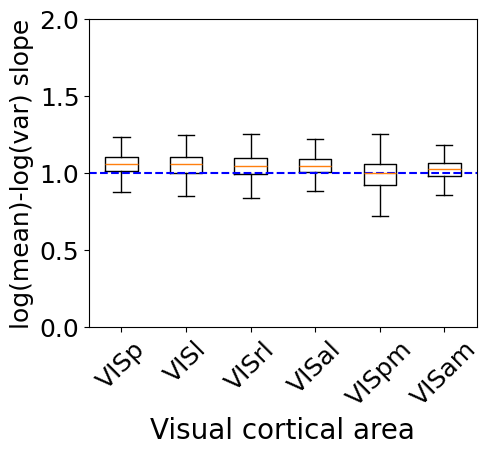

In [ ]:
# box plot

with open('resp_matrix_ep_HVA_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_HVA_allensdk = pickle.load(f)

    list_slopes_flattened2_HVA = dc(resp_matrix_ep_HVA_allensdk['list_slopes_flattened2'])

list_vis_areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

list_slopes_flattened2_HVA = [slopes_flattened[~np.isnan(slopes_flattened)] for slopes_flattened in list_slopes_flattened2_HVA]

ax.boxplot([*list_slopes_flattened2_HVA], showfliers=False)
ax.axhline(1, color='b', linestyle='--')

ax.set_ylim(0, 2)

ax.set_xticklabels(list_vis_areas)
ax.set_xlabel('Visual cortical area', fontsize=20)
ax.set_ylabel('log(mean)-log(var) slope', fontsize=18)
ax.tick_params('both', labelsize=18)
ax.tick_params('x', labelrotation=45)

plt.show()

## Figure 1C top

session index: 3
110


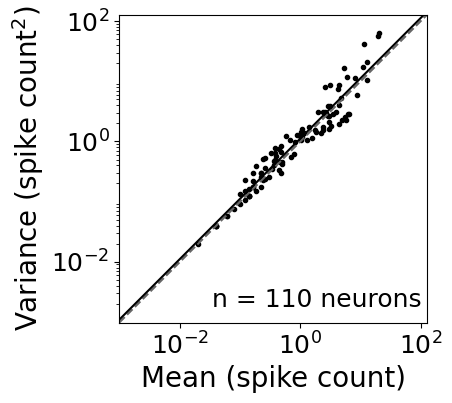

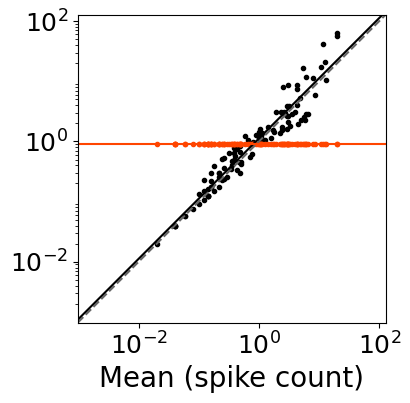

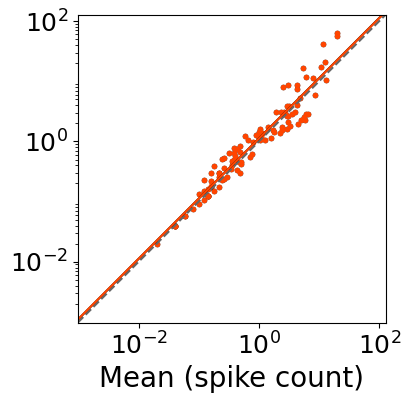

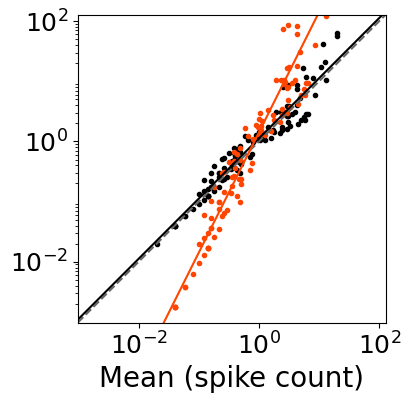

In [26]:
# Scatterplot & Model Lines across neurons (ABO Neuropixels all neurons)

list_target_slopes = [0, 1, 2]

# Iterate over all sessions
for sess_ind, rate in enumerate(list_rate_all):
    if sess_ind == 3:

        print(f'session index: {sess_ind}')
        
        rate_sorted = rate.sort_index(axis=1)
        stm = rate_sorted.columns.copy()

        # Multiply by delta t to convert to spike counts
        rate_sorted = rate_sorted * 0.25
        print(rate_sorted.shape[0])

        # Create a counting dictionary for each stimulus
        all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
        stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

        # Compute mean & variance for each stimulus
        rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate_sorted)
        rate_sorted_FF_dr = rate_sorted_var.div(rate_sorted_mean)

        rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate_sorted)

        list_slopes_dr = pd.DataFrame(list_slopes_all_an_loglog[sess_ind], \
                                    columns=rate_sorted_mean_coll.columns).copy()

        # scatterplot & model lines
                            
        list_trial_types = rate_sorted_mean_coll.columns.copy()

        fig, axes = plt.subplots(1, 1, figsize=(4, 4))
        axes = np.array(axes).flatten()

        for trial_type_ind, trial_type in enumerate(list_trial_types):
            if trial_type_ind == 18:
                trial_type_ind = 0
            
                axes[trial_type_ind].set_aspect('equal')

                axes[trial_type_ind].scatter(rate_sorted_mean_coll.loc[:, trial_type], rate_sorted_var_coll.loc[:, trial_type], c='k', marker='.')
                # axes[trial_type_ind].scatter(rate_mean_RRneuron_coll.loc[:, trial_type], rate_var_RRneuron_coll.loc[:, trial_type], c='orangered', marker='.')

                # Range for x/y axes
                min_ = np.min([rate_sorted_mean_coll.loc[:, trial_type], rate_sorted_var_coll.loc[:, trial_type]]) + 2**(-10)  # add pseudo-value to avoid log 0
                max_ = np.max([rate_sorted_mean_coll.loc[:, trial_type], rate_sorted_var_coll.loc[:, trial_type]]) * 2
        
                axes[trial_type_ind].set_xlim(min_, max_)
                axes[trial_type_ind].set_ylim(min_, max_)
                axes[trial_type_ind].set_xscale('log')
                axes[trial_type_ind].set_yscale('log')
                axes[trial_type_ind].set_yticks(np.logspace(-2, 2, 3, endpoint=True, base=10))
            
                axes[trial_type_ind].set_xlabel('Mean (spike count)', fontsize=20)
                axes[trial_type_ind].set_ylabel('Variance (spike count$^2$)', fontsize=20)
                axes[trial_type_ind].tick_params(axis='both', labelsize=18)

                # lines
                x = np.linspace(min_, max_)
                axes[trial_type_ind].plot(x, x, color='0.4', linestyle='--') # y = x line

                axes[trial_type_ind].plot(x, pow(10, list_slopes_dr.loc[1, trial_type])*x**list_slopes_dr.loc[0, trial_type], color='k')
                axes[trial_type_ind].annotate(f'n = {rate_sorted_mean_coll.shape[0]} neurons', xy=(0.3, 0.05), xycoords='axes fraction', color='k', fontsize=18)
            
        plt.subplots_adjust(wspace=0.1, hspace=0.3)
        plt.savefig('..\\..\\code_images\\neural_variability_robustness\\mvplot_asis.svg', bbox_inches='tight')
        plt.show()
        
        # Change slope
        for slope_ind, target_slope in enumerate(list_target_slopes):

            # Convert 0 to NaN (verified that cases of mean=0 and var=0 coincide exactly)
            rate_sorted_mean_coll[rate_sorted_mean_coll == 0] = np.nan
            rate_sorted_var_coll[rate_sorted_var_coll == 0] = np.nan

            # calculate target variance
            var_estim_dr = pd.DataFrame(np.zeros((1, rate_sorted_var_coll.shape[1])), \
                                    columns=rate_sorted_var_coll.columns) 
            for trial_type in rate_sorted_var_coll.columns:
                var_estim_dr.loc[:, trial_type] = \
                    np.nanmean(rate_sorted_var.loc[:, trial_type].values.flatten()) # nanmean
            # var_estim_dr = np.repeat(var_estim_dr, all_stm_counts, axis=1) 
            # print(var_estim_dr)

            # offset = var_estim_dr.div(rate_sorted_var_coll.pow(target_slope/list_slopes_dr.iloc[0, :], axis=1).mean(axis=0))\
            # .mul(pow(10, target_slope * list_slopes_dr.iloc[1, :] / list_slopes_dr.iloc[0, :])) # collapsed 
            offset = pow(10, (list_slopes_dr.iloc[0, :]-target_slope) * np.nanmean(np.log10(rate_sorted_mean_coll), axis=0) + list_slopes_dr.iloc[1, :]) 

            var_rs_noisy = \
                pow(10, np.log10(rate_sorted_var_coll).sub(list_slopes_dr.iloc[1, :], axis=1)\
                    .div(list_slopes_dr.iloc[0, :], axis=1).mul(target_slope).add(np.log10(np.array(offset)), axis=1)) # collapsed
            var_rs_noisy = np.repeat(np.array(var_rs_noisy), all_stm_counts, axis=1) 

            # Compute changed residual and add back to the mean            
            rate_sorted_resid_dr = rate_sorted - rate_sorted_mean
            # rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
            #     .mul(np.sqrt(rate_sorted_mean)).mul(np.sqrt(FF_estim_dr), axis=1)
            rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
                .mul(np.sqrt(var_rs_noisy))
            # print(rate_resid_RRneuron_dr)
            rate_RRneuron_dr = rate_sorted_mean + rate_resid_RRneuron_dr
            rate_RRneuron_dr[rate_RRneuron_dr.isna()] = 0 # convert NaN to 0!    

            # Compute mean and variance of slope-changed data
            rate_mean_RRneuron_coll, rate_var_RRneuron_coll = \
                compute_mean_var_trial_collapse(stm_cnt_dict, rate_RRneuron_dr)
            # FF_RRneuron = rate_var_RRneuron_dr.div(rate_mean_RRneuron_dr)
            # print(FF_RRneuron)
            # print(rate_var_RRneuron_dr)

            # convert NaN to 0
            rate_sorted_mean_coll[rate_sorted_mean_coll.isna()] = 0
            rate_sorted_var_coll[rate_sorted_var_coll.isna()] = 0

            # scatterplot & model lines
                                
            list_trial_types = rate_sorted_mean_coll.columns.copy()

            fig, axes = plt.subplots(1, 1, figsize=(4, 4))
            axes = np.array(axes).flatten()

            for trial_type_ind, trial_type in enumerate(list_trial_types):
                if trial_type_ind == 18:
                    trial_type_ind = 0
                
                    axes[trial_type_ind].set_aspect('equal')

                    axes[trial_type_ind].scatter(rate_sorted_mean_coll.loc[:, trial_type], rate_sorted_var_coll.loc[:, trial_type], c='k', marker='.')
                    axes[trial_type_ind].scatter(rate_mean_RRneuron_coll.loc[:, trial_type], rate_var_RRneuron_coll.loc[:, trial_type], c='orangered', marker='.')

                    # Range for x/y axes
                    min_ = np.min([rate_sorted_mean_coll.loc[:, trial_type], rate_sorted_var_coll.loc[:, trial_type]]) + 2**(-10)  # add pseudo-value to avoid log 0
                    max_ = np.max([rate_sorted_mean_coll.loc[:, trial_type], rate_sorted_var_coll.loc[:, trial_type]]) * 2
            
                    axes[trial_type_ind].set_xlim(min_, max_)
                    axes[trial_type_ind].set_ylim(min_, max_)
                    axes[trial_type_ind].set_xscale('log')
                    axes[trial_type_ind].set_yscale('log')
                    axes[trial_type_ind].set_yticks(np.logspace(-2, 2, 3, endpoint=True, base=10))
                
                    axes[trial_type_ind].set_xlabel('Mean (spike count)', fontsize=20)
                    # axes[trial_type_ind].set_ylabel('Variance (spike count$^2$)', fontsize=20)
                    axes[trial_type_ind].tick_params(axis='both', labelsize=18)

                    # lines
                    x = np.linspace(min_, max_)
                    axes[trial_type_ind].plot(x, x, color='0.4', linestyle='--') # y = x line

                    axes[trial_type_ind].plot(x, pow(10, list_slopes_dr.loc[1, trial_type])*x**list_slopes_dr.loc[0, trial_type], color='k')
                    # axes[trial_type_ind].annotate(f'n = {rate_sorted_mean_coll.shape[0]} neurons', xy=(0.3, 0.05), xycoords='axes fraction', color='k', fontsize=18)

                    axes[trial_type_ind].plot(x, offset.loc[trial_type]*x**target_slope, color='orangered')
                
            plt.subplots_adjust(wspace=0.1, hspace=0.3)
            plt.savefig(f'..\\..\\code_images\\neural_variability_robustness\\mvplot_slope{target_slope}.svg', bbox_inches='tight')
            plt.show()

## Figure S5A

median = 1.11

frame_ind = 2



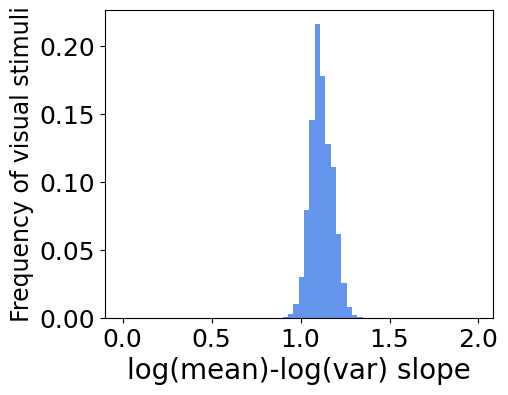

Kruskal-Wallis p = 0.0000


In [ ]:
# Linear Fitting Slope across neurons (ABO Neuropixels all neurons) (loglog line) (natural movie) (1frame: ~16 min, 8/12frame: ~1.5 min)

with open('resp_matrix_ep_naturalmovie_FC_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_naturalmovie = pickle.load(f)

    list_n_tt_frames = resp_matrix_ep_naturalmovie['list_n_tt_frames'].copy()
    list_delta_t = resp_matrix_ep_naturalmovie['list_delta_t'].copy()    
    brain_observatory_sessid = resp_matrix_ep_naturalmovie['brain_observatory_sessid'].copy()
    list_sess_ids = resp_matrix_ep_naturalmovie['list_sess_ids'].copy()
    list_rate_one_all = resp_matrix_ep_naturalmovie['list_rate_one_all'].copy()
    list_rate_three_all = resp_matrix_ep_naturalmovie['list_rate_three_all'].copy()
    list_slopes_nm_all_an_loglog2 = resp_matrix_ep_naturalmovie['list_slopes_nm_all_an_loglog2'].copy()
    list_slopes_nm_flattened2 = resp_matrix_ep_naturalmovie['list_slopes_flattened2'].copy()

num_sess = sessions.shape[0]

fig, ax = plt.subplots(figsize=(5, 4))

list_n_tt_frames = [1, 8, 12]
list_delta_t = [0.033, 0.267, 0.4]
# list_slopes_nm_flattened2 = np.empty(len(list_n_tt_frames), dtype=object)
# list_slopes_nm_all_an_loglog2 = np.empty(len(list_n_tt_frames), dtype=object)
for frame_ind, n_tt_frame in enumerate(list_n_tt_frames):
    if frame_ind == 2:
        
        # # Iterate over all sessions
        # list_slopes_nm_all_an_loglog = np.empty(num_sess, dtype=object)
        # for sess_ind, sess_id in enumerate(list_sess_ids):
        #     # if ~np.any(np.isin(sess_ind, [4, 13, 42, 48, 49])): # 4, 13, 42: movie one truncation; 48, 49: no V1 neurons
        #     if ~np.isin(sess_id, brain_observatory_sessid) and ~np.any(np.isin(sess_ind, [4, 13, 42, 48, 49])): # only "functional connectivity" sessions.
        #         print(f'sess_ind: {sess_ind}')
            
        #         rate_one = list_rate_one_all[sess_ind, frame_ind].sort_index(axis=1)
        #         rate_one.columns = rate_one.columns + 0.1 # tag for movie one
        #         rate = rate_one.copy()
        #         stm = rate_one.columns.copy()
                
        #         if np.isin(sess_id, brain_observatory_sessid):
        #             rate_three = list_rate_three_all[sess_ind, frame_ind].sort_index(axis=1)
        #             rate_three.columns = rate_three.columns + 0.3 # tag for movie three

        #             rate = pd.concat([rate_one, rate_three], axis=1) # movie one & three concatenation
        #             stm = rate.columns.copy()
        #         else:
        #             rate = rate_one.copy()
        #             stm = rate_one.columns.copy()

        #         # Multiply by delta t to convert to spike counts
        #         rate = round(rate * list_delta_t[frame_ind])

        #         # Create a counting dictionary for each stimulus
        #         all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
        #         stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

        #         # Compute mean & variance for each stimulus
        #         rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate)
        #         rate_sorted_FF = rate_sorted_var.div(rate_sorted_mean)

        #         rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate)

        #         # Calculate and collect linear slopes for all stimuli
        #         slopes_nm = np.zeros((2, rate_sorted_mean_coll.shape[1]))
        #         for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):

        #             # # arithmetic scale
        #             # popt = np.polyfit(rate_sorted_mean.loc[neu_ind, :].astype(np.float32), \
        #             #                     rate_sorted_FF.loc[neu_ind, :].astype(np.float32), 1)
        #             # slopes_nm[ind] = popt[0]

        #             # loglog scale
        #             bool_var_notzero = rate_sorted_var_coll.loc[:, trial_type] > 0
        #             popt = np.polyfit(np.log10(rate_sorted_mean.loc[bool_var_notzero, trial_type].values).flatten().astype(np.float32), \
        #                                 np.log10(rate_sorted_var.loc[bool_var_notzero, trial_type].values).flatten().astype(np.float32), 1)
        #             # popt = np.polyfit(np.log10(rate_sorted_mean.loc[:, trial_type].values).flatten().astype(np.float32), \
        #             #                      np.log10(rate_sorted_var.loc[:, trial_type].values).flatten().astype(np.float32), 1)
                    
        #             slopes_nm[:, trial_type_ind] = popt.copy()
                
        #         list_slopes_nm_all_an_loglog[sess_ind] = slopes_nm.copy()

        # list_slopes_nm_all_an_loglog2[frame_ind] = list_slopes_nm_all_an_loglog.copy()

        # Histogram of slopes (all sessions)
        list_slopes_nm_all_an_loglog = dc(list_slopes_nm_all_an_loglog2[frame_ind])
        list_slopes_nm_all_an_loglog_flattened = np.concatenate([slopes_nm[0, :].flatten() for slopes_nm in list_slopes_nm_all_an_loglog if slopes_nm is not None])
        bin_size = 0.03
        lower_bound, upper_bound = math.floor(np.nanmin(list_slopes_nm_all_an_loglog_flattened)), \
            math.ceil(np.nanmax(list_slopes_nm_all_an_loglog_flattened))

        weights=np.ones_like(list_slopes_nm_all_an_loglog_flattened)/len(list_slopes_nm_all_an_loglog_flattened)
        ax.hist(list_slopes_nm_all_an_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
                weights=weights, color='cornflowerblue') 
        # plt.axvline(1, color='r', linestyle='--')

        print(f'median = {np.nanmedian(list_slopes_nm_all_an_loglog_flattened):.2f}')

        # list_slopes_nm_flattened2[frame_ind] = list_slopes_nm_all_an_loglog_flattened.copy()
        print(f'\nframe_ind = {frame_ind}\n')

ax.set_xlabel('log(mean)-log(var) slope', fontsize=20)
ax.set_ylabel('Number of visual stimuli', fontsize=18)
ax.set_ylabel('Frequency of visual stimuli', fontsize=17)
ax.set_xticks([0, 0.5, 1, 1.5, 2])
# ax.set_yticks([100, 300, 500, 700])
ax.tick_params('both', labelsize=18)

# ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

plt.show()

# Kruskal-Wallis test
pval_slopes_nm = kruskal(*list_slopes_nm_flattened2, nan_policy='omit').pvalue
print(f'Kruskal-Wallis p = {pval_slopes_nm:.4f}')

In [38]:
# with open('resp_matrix_ep_naturalmovie_FC_allensdk.pickle', 'wb') as f:
#     pickle.dump({'tree_variables': ['list_rate_one_all', 'list_rate_three_all', 'list_n_tt_frames', 'list_delta_t', 'list_slopes_nm_all_an_loglog2', 'list_slopes_flattened2', 'list_sess_ids', 'brain_observatory_sessid'],
#                  'list_rate_one_all': list_rate_one_all, 'list_rate_three_all': list_rate_three_all,
#                  'list_n_tt_frames': list_n_tt_frames, 'list_delta_t': list_delta_t, 'list_slopes_nm_all_an_loglog2': list_slopes_nm_all_an_loglog2, 'list_slopes_flattened2': list_slopes_flattened2,
#                  'list_sess_ids': list_sess_ids, 'brain_observatory_sessid': brain_observatory_sessid}, f)

# with open('resp_matrix_ep_naturalmovie_allensdk.pickle', 'wb') as f:
#     pickle.dump({'tree_variables': ['list_rate_one_all', 'list_rate_three_all', 'list_n_tt_frames', 'list_delta_t', 'list_slopes_nm_all_an_loglog2', 'list_slopes_flattened2', 'list_sess_ids', 'brain_observatory_sessid'],
#                  'list_rate_one_all': list_rate_one_all, 'list_rate_three_all': list_rate_three_all,
#                  'list_n_tt_frames': list_n_tt_frames, 'list_delta_t': list_delta_t, 'list_slopes_nm_all_an_loglog2': list_slopes_nm_all_an_loglog2, 'list_slopes_flattened2': list_slopes_flattened2,
#                  'list_sess_ids': list_sess_ids, 'brain_observatory_sessid': brain_observatory_sessid}, f)

In [39]:
# check low quality session (all-zero trials exceed 10% of total trials)

with open('resp_matrix_ep_naturalmovie_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_naturalmovie = pickle.load(f)

    list_n_tt_frames = resp_matrix_ep_naturalmovie['list_n_tt_frames'].copy()
    list_delta_t = resp_matrix_ep_naturalmovie['list_delta_t'].copy()
    brain_observatory_sessid = resp_matrix_ep_naturalmovie['brain_observatory_sessid'].copy()
    list_sess_ids = resp_matrix_ep_naturalmovie['list_sess_ids'].copy()
    list_rate_one_all = resp_matrix_ep_naturalmovie['list_rate_one_all'].copy()
    list_rate_three_all = resp_matrix_ep_naturalmovie['list_rate_three_all'].copy()

num_sess = list_sess_ids.shape[0]

list_n_tt_frames = [1, 8, 12]
list_delta_t = [0.033, 0.267, 0.4]
list_lowq_sess_nm = np.full(num_sess, np.nan)
for frame_ind, n_tt_frame in enumerate(list_n_tt_frames):
    if frame_ind == 2:
        
        # Iterate over all sessions
        for sess_ind, sess_id in enumerate(list_sess_ids):
            # if ~np.any(np.isin(sess_ind, [4, 13, 42, 48, 49])): # 4, 13, 42: movie one truncation; 48, 49: no V1 neurons
            if ~np.isin(sess_id, brain_observatory_sessid) and ~np.any(np.isin(sess_ind, [4, 13, 42, 48, 49])): # only "functional connectivity" sessions.
                # print(f'sess_ind: {sess_ind}')
            
                rate_one = list_rate_one_all[sess_ind, frame_ind].sort_index(axis=1)
                rate_one.columns = rate_one.columns + 0.1 # tag for movie one
                rate = rate_one.copy()
                stm = rate_one.columns.copy()
                
                if np.isin(sess_id, brain_observatory_sessid):
                    rate_three = list_rate_three_all[sess_ind, frame_ind].sort_index(axis=1)
                    rate_three.columns = rate_three.columns + 0.3 # tag for movie three

                    rate = pd.concat([rate_one, rate_three], axis=1) # movie one & three concatenation
                    stm = rate.columns.copy()
                else:
                    rate = rate_one.copy()
                    stm = rate_one.columns.copy()

                # Multiply by delta t to convert to spike counts
                rate = round(rate * list_delta_t[frame_ind])

                list_lowq_sess_nm[sess_ind] = np.all(rate == 0, axis=0).sum() / rate.shape[1]

print(list_lowq_sess_nm)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan  0.  0.  0.  0.  0. nan  0.  0.  0.
  0.  0.  0.  0.  0. nan nan  0. nan nan nan  0. nan nan  0.  0.  0.  0.
  0.  0.  0.  0.]


In [40]:
# num_sess = 32

# # ~ 1 min 15 sec
# list_sessions = np.empty(num_sess, dtype=object)
# for sess_ind, sess_id in enumerate(brain_observatory_sessid):
#     print(f'sess_ind = {sess_ind}')
#     list_sessions[sess_ind] = cache.get_session_data(sess_id)

In [41]:
# # Save time and velocity for each session and trial (~5 min)
# num_sess = 32
# list_speed_sess = np.empty(num_sess, dtype=object)
# for sess_ind, sess_id in enumerate(brain_observatory_sessid):
#     print(f'sess_ind = {sess_ind}')
    
#     session = list_sessions[sess_ind]
#     ns_times = session.get_stimulus_table()[session.get_stimulus_table()['stimulus_name'] == 'natural_scenes'][['start_time', 'stop_time', 'frame']].copy()
#     speed = session.running_speed.copy()

#     # Iterate over trials
#     list_speed_trial = np.empty(ns_times.shape[0], dtype=object)
#     for trial_ind, stim_present_ind in enumerate(ns_times.index):
#         # print(f'trial_ind = {trial_ind}')

#         trial_start, trial_stop = ns_times.loc[stim_present_ind, 'start_time'], ns_times.loc[stim_present_ind, 'stop_time']
#         trial_mask = (speed.loc[:, 'start_time'] >= trial_start) & (speed.loc[:, 'end_time'] <= trial_stop)

#         list_speed_trial[trial_ind] = speed.loc[trial_mask].copy()

#     list_speed_sess[sess_ind] = list_speed_trial.copy()

In [42]:
# # Average running speed within each trial
# list_mean_speed_sess = np.empty(num_sess, dtype=object)
# for sess_ind, sess_id in enumerate(brain_observatory_sessid):

#     # Iterate over trials
#     num_tot_trials = list_speed_sess[sess_ind].shape[0]

#     list_mean_speed_trial = np.zeros(num_tot_trials)
#     for trial_ind, stim_present_ind in enumerate(range(num_tot_trials)):
#         list_mean_speed_trial[trial_ind] = np.mean(list_speed_sess[sess_ind][trial_ind].loc[:, 'velocity'])
#     list_mean_speed_sess[sess_ind] = list_mean_speed_trial

In [43]:
# with open('ep_natural_scenes_loco.pickle', 'wb') as f:
#     pickle.dump({'tree_variables': ['list_speed_sess', 'list_mean_speed_sess'],
#                  'list_speed_sess': list_speed_sess, 'list_mean_speed_sess': list_mean_speed_sess}, f)

In [44]:
# # Divide trials based on running speed and fit mean-var slope 

# with open('ep_natural_scenes_loco.pickle', 'rb') as f:
#     ep_natural_scenes_loco = pickle.load(f)
#     list_mean_speed_sess = ep_natural_scenes_loco['list_mean_speed_sess'].copy()

# num_trial_types = 119

# # Iterate over all sessions
# list_slopes_stat_all_an_loglog = np.empty(num_sess, dtype=object) # stationary trials
# for sess_ind, rate in enumerate(list_rate_all):
#     # if sess_ind == 21:
#         print(f'session index: {sess_ind}')
        
#         rate = rate.loc[:, list_mean_speed_sess[sess_ind] < 1].copy() # stationary

#         rate = rate.sort_index(axis=1)
#         stm = rate.columns.copy()

#         # Multiply by delta t to convert to spike counts
#         rate = rate * 0.25

#         # Create a counting dictionary for each stimulus
#         all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
#         stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))
#         print(all_stm_unique.shape)

#         # Compute mean & variance for each stimulus
#         rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate)
#         rate_sorted_FF = rate_sorted_var.div(rate_sorted_mean)

#         rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate)

#         # Calculate and collect linear slopes for all stimuli
#         slopes = pd.DataFrame(np.full((2, num_trial_types), np.nan), columns=np.arange(-1, 118, 1).astype(int))
#         for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):

#             # # arithmetic scale
#             # popt = np.polyfit(rate_sorted_mean.loc[neu_ind, :].astype(np.float32), \
#             #                     rate_sorted_FF.loc[neu_ind, :].astype(np.float32), 1)
#             # slopes[ind] = popt[0]

#             # loglog scale
#             bool_var_notzero = rate_sorted_var_coll.loc[:, trial_type] > 0
#             if bool_var_notzero.sum() > 10: # Minimum number of neurons for reliable linear regression
#                 popt = np.polyfit(np.log10(rate_sorted_mean.loc[bool_var_notzero, trial_type].values).flatten().astype(np.float32), \
#                                     np.log10(rate_sorted_var.loc[bool_var_notzero, trial_type].values).flatten().astype(np.float32), 1)
#                 # popt = np.polyfit(np.log10(rate_sorted_mean.loc[:, trial_type].values).flatten().astype(np.float32), \
#                 #                      np.log10(rate_sorted_var.loc[:, trial_type].values).flatten().astype(np.float32), 1)
                
#                 slopes.loc[:, trial_type] = popt.copy()
        
#         list_slopes_stat_all_an_loglog[sess_ind] = slopes.copy()

# # Histogram of slopes (all sessions)
# fig, ax = plt.subplots(figsize=(5, 4))

# list_slopes_stat_all_an_loglog_flattened = np.concatenate([slopes.iloc[0, :].to_numpy() for slopes in list_slopes_stat_all_an_loglog])
# bin_size = 0.03
# lower_bound, upper_bound = math.floor(np.nanmin(list_slopes_stat_all_an_loglog_flattened)), \
#     math.ceil(np.nanmax(list_slopes_stat_all_an_loglog_flattened))

# ax.hist(list_slopes_stat_all_an_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
#         color='cornflowerblue')
# # plt.axvline(1, color='r', linestyle='--')

# ax.set_title('Natural Scenes Stationary', fontsize=20)
# ax.set_xlabel('Slope', fontsize=18)
# ax.set_ylabel('Number of stimuli', fontsize=18)
# # ax.set_xticks([0, 0.5, 1, 1.5, 2])
# # ax.set_yticks([100, 300, 500, 700])
# ax.tick_params('both', labelsize=16)

# plt.show()

# print(f'median = {np.nanmedian(list_slopes_stat_all_an_loglog_flattened):.2f}')
# print(f'num_total_counts = {list_slopes_stat_all_an_loglog_flattened[~np.isnan(list_slopes_stat_all_an_loglog_flattened)].shape[0]}')

In [45]:
# # Divide trials based on running speed and fit mean-var slope 

# with open('ep_natural_scenes_loco.pickle', 'rb') as f:
#     ep_natural_scenes_loco = pickle.load(f)
#     list_mean_speed_sess = ep_natural_scenes_loco['list_mean_speed_sess'].copy()
    
# num_trial_types = 119

# # Iterate over all sessions
# list_slopes_mov_all_an_loglog = np.empty(num_sess, dtype=object) # stationary trials
# for sess_ind, rate in enumerate(list_rate_all):
#     # if sess_ind == 21:
#         print(f'session index: {sess_ind}')
        
#         rate = rate.loc[:, list_mean_speed_sess[sess_ind] >= 1].copy() # moving

#         rate = rate.sort_index(axis=1)
#         stm = rate.columns.copy()

#         # Multiply by delta t to convert to spike counts
#         rate = rate * 0.25

#         # Create a counting dictionary for each stimulus
#         all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
#         stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))
#         print(all_stm_unique.shape)

#         # Compute mean & variance for each stimulus
#         rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate)
#         rate_sorted_FF = rate_sorted_var.div(rate_sorted_mean)

#         rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate)

#         # Calculate and collect linear slopes for all stimuli
#         slopes = pd.DataFrame(np.full((2, num_trial_types), np.nan), columns=np.arange(-1, 118, 1).astype(int))
#         for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):

#             # # arithmetic scale
#             # popt = np.polyfit(rate_sorted_mean.loc[neu_ind, :].astype(np.float32), \
#             #                     rate_sorted_FF.loc[neu_ind, :].astype(np.float32), 1)
#             # slopes[ind] = popt[0]

#             # loglog scale
#             bool_var_notzero = rate_sorted_var_coll.loc[:, trial_type] > 0
#             if bool_var_notzero.sum() > 10: # Minimum number of neurons for reliable linear regression
#                 popt = np.polyfit(np.log10(rate_sorted_mean.loc[bool_var_notzero, trial_type].values).flatten().astype(np.float32), \
#                                     np.log10(rate_sorted_var.loc[bool_var_notzero, trial_type].values).flatten().astype(np.float32), 1)
#                 # popt = np.polyfit(np.log10(rate_sorted_mean.loc[:, trial_type].values).flatten().astype(np.float32), \
#                 #                      np.log10(rate_sorted_var.loc[:, trial_type].values).flatten().astype(np.float32), 1)
                
#                 slopes.loc[:, trial_type] = popt.copy()
        
#         list_slopes_mov_all_an_loglog[sess_ind] = slopes.copy()

# # Histogram of slopes (all sessions)
# fig, ax = plt.subplots(figsize=(5, 4))

# list_slopes_mov_all_an_loglog_flattened = np.concatenate([slopes.iloc[0, :].to_numpy() for slopes in list_slopes_mov_all_an_loglog])
# bin_size = 0.03
# lower_bound, upper_bound = math.floor(np.nanmin(list_slopes_mov_all_an_loglog_flattened)), \
#     math.ceil(np.nanmax(list_slopes_mov_all_an_loglog_flattened))

# ax.hist(list_slopes_mov_all_an_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
#         color='cornflowerblue')
# # plt.axvline(1, color='r', linestyle='--')

# ax.set_title('Natural Scenes Moving', fontsize=20)
# ax.set_xlabel('Slope', fontsize=18)
# ax.set_ylabel('Number of stimuli', fontsize=18)
# # ax.set_xticks([0, 0.5, 1, 1.5, 2])
# # ax.set_yticks([100, 300, 500, 700])
# ax.tick_params('both', labelsize=16)

# plt.show()

# print(f'median = {np.nanmedian(list_slopes_mov_all_an_loglog_flattened):.2f}')
# print(f'num_total_counts = {list_slopes_mov_all_an_loglog_flattened[~np.isnan(list_slopes_mov_all_an_loglog_flattened)].shape[0]}')

## Figure S2A left

[8929135.0, 0.0]


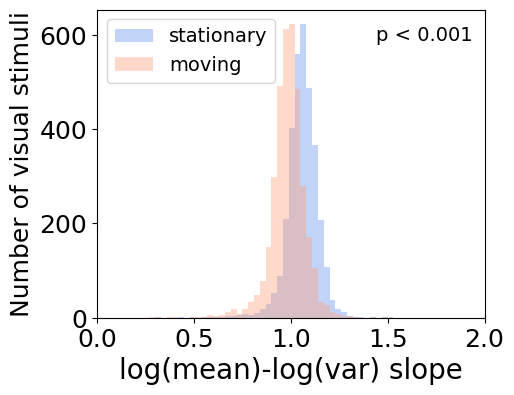

In [46]:
# histogram (locomotion)

fig, ax = plt.subplots(figsize=(5, 4))

# stationary trials
list_slopes_stat_all_an_loglog_flattened = np.concatenate([slopes.iloc[0, :].to_numpy() for sess_ind, slopes in enumerate(list_slopes_stat_all_an_loglog) if sess_ind != 0 and sess_ind != 6])
bin_size = 0.03
lower_bound, upper_bound = math.floor(np.nanmin(list_slopes_stat_all_an_loglog_flattened)), \
    math.ceil(np.nanmax(list_slopes_stat_all_an_loglog_flattened))

ax.hist(list_slopes_stat_all_an_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
        color='cornflowerblue', alpha=0.4, label='stationary')

# moving trials
list_slopes_mov_all_an_loglog_flattened = np.concatenate([slopes.iloc[0, :].to_numpy() for sess_ind, slopes in enumerate(list_slopes_mov_all_an_loglog) if sess_ind != 0 and sess_ind != 6])
bin_size = 0.03
lower_bound, upper_bound = math.floor(np.nanmin(list_slopes_mov_all_an_loglog_flattened)), \
    math.ceil(np.nanmax(list_slopes_mov_all_an_loglog_flattened))

ax.hist(list_slopes_mov_all_an_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
        color='lightsalmon', alpha=0.4, label='moving')
# plt.axvline(1, color='r', linestyle='--')

# ax.set_title('Natural Scenes Locomotion', fontsize=20)
ax.set_xlabel('log(mean)-log(var) slope', fontsize=20)
ax.set_ylabel('Number of visual stimuli', fontsize=18)
# ax.set_xticks([0, 0.5, 1, 1.5, 2])
# ax.set_yticks([100, 300, 500, 700])
ax.tick_params('both', labelsize=18)
ax.legend(loc='upper left', prop={'size': 14})

ax.set_xlim(0, 2)

# Wilcoxon ranksum test
wilc = list(mannwhitneyu(list_slopes_stat_all_an_loglog_flattened, list_slopes_mov_all_an_loglog_flattened, alternative='two-sided', nan_policy='omit'))
print(wilc)
ax.annotate(f'p < 0.001', xy=(0.72, 0.9), xycoords='axes fraction', fontsize=14)

plt.show()

## Figure S2A right

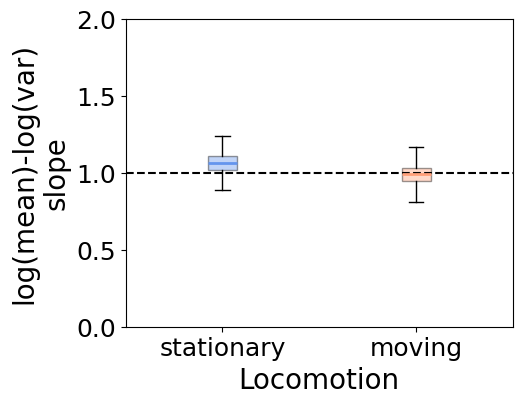

In [47]:
# box plot

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

list_slopes_flattened2 = dc([list_slopes_stat_all_an_loglog_flattened, list_slopes_mov_all_an_loglog_flattened])
list_slopes_flattened2 = [slopes_flattened[~np.isnan(slopes_flattened)] for slopes_flattened in list_slopes_flattened2]

box = ax.boxplot(list_slopes_flattened2, showfliers=False, tick_labels=['stationary', 'moving'], patch_artist=True)

# Set colors
box['boxes'][0].set(facecolor='cornflowerblue', alpha=0.4) # box color
box['boxes'][1].set(facecolor='lightsalmon', alpha=0.4)
box['medians'][0].set(color='cornflowerblue', linewidth=2) # median line color
box['medians'][1].set(color='lightsalmon', linewidth=2)

ax.axhline(1, color='k', linestyle='--')

ax.set_ylim(0, 2)
# ax.set_ylim(-1, 1)
ax.set_xlabel('Locomotion', fontsize=20)
ax.set_ylabel('log(mean)-log(var)\nslope', fontsize=20)
ax.tick_params('both', labelsize=18)
# plt.xticks(rotation=20)

plt.show()

## Figure S2B left

[8303642.0, 4.2773022682955094e-207]


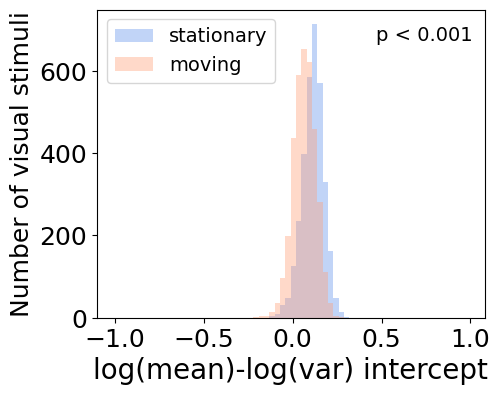

In [48]:
# histogram (locomotion)

fig, ax = plt.subplots(figsize=(5, 4))

# stationary trials
list_intcpts_stat_all_an_loglog_flattened = np.concatenate([intcpts.iloc[1, :].to_numpy() for sess_ind, intcpts in enumerate(list_slopes_stat_all_an_loglog) if sess_ind != 0 and sess_ind != 6])
bin_size = 0.03
lower_bound, upper_bound = math.floor(np.nanmin(list_intcpts_stat_all_an_loglog_flattened)), \
    math.ceil(np.nanmax(list_intcpts_stat_all_an_loglog_flattened))

ax.hist(list_intcpts_stat_all_an_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
        color='cornflowerblue', alpha=0.4, label='stationary')

# moving trials
list_intcpts_mov_all_an_loglog_flattened = np.concatenate([intcpts.iloc[1, :].to_numpy() for sess_ind, intcpts in enumerate(list_slopes_mov_all_an_loglog) if sess_ind != 0 and sess_ind != 6])
bin_size = 0.03
lower_bound, upper_bound = math.floor(np.nanmin(list_intcpts_mov_all_an_loglog_flattened)), \
    math.ceil(np.nanmax(list_intcpts_mov_all_an_loglog_flattened))

ax.hist(list_intcpts_mov_all_an_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
        color='lightsalmon', alpha=0.4, label='moving')
# plt.axvline(1, color='r', linestyle='--')

# ax.set_title('Natural Scenes Locomotion', fontsize=20)
ax.set_xlabel('log(mean)-log(var) intercept', fontsize=20)
ax.set_ylabel('Number of visual stimuli', fontsize=18)
# ax.set_xticks([0, 0.5, 1, 1.5, 2])
# ax.set_yticks([100, 300, 500, 700])
ax.tick_params('both', labelsize=18)
ax.legend(loc='upper left', prop={'size': 14})

# ax.set_xlim(0, 2)

# Wilcoxon ranksum test
wilc = list(mannwhitneyu(list_intcpts_stat_all_an_loglog_flattened, list_intcpts_mov_all_an_loglog_flattened, alternative='two-sided', nan_policy='omit'))
print(wilc)
ax.annotate(f'p < 0.001', xy=(0.72, 0.9), xycoords='axes fraction', fontsize=14)

plt.show()

## Figure S2B right

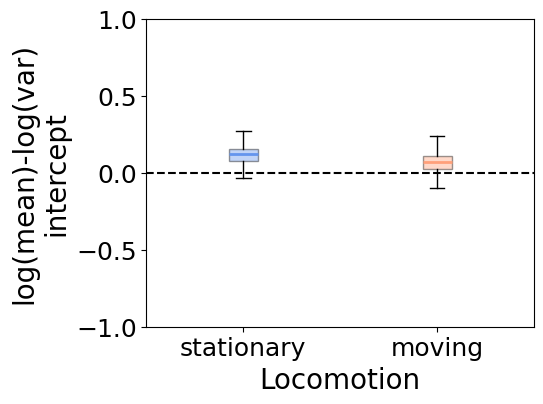

In [49]:
# box plot

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

list_intcpts_flattened2 = dc([list_intcpts_stat_all_an_loglog_flattened, list_intcpts_mov_all_an_loglog_flattened])
list_intcpts_flattened2 = [intcpts_flattened[~np.isnan(intcpts_flattened)] for intcpts_flattened in list_intcpts_flattened2]

box = ax.boxplot(list_intcpts_flattened2, showfliers=False, tick_labels=['stationary', 'moving'], patch_artist=True)

# Set colors
box['boxes'][0].set(facecolor='cornflowerblue', alpha=0.4) # box color
box['boxes'][1].set(facecolor='lightsalmon', alpha=0.4)
box['medians'][0].set(color='cornflowerblue', linewidth=2) # median line color
box['medians'][1].set(color='lightsalmon', linewidth=2)

ax.axhline(0, color='k', linestyle='--')

# ax.set_ylim(0, 2)
ax.set_ylim(-1, 1)
ax.set_xlabel('Locomotion', fontsize=20)
ax.set_ylabel('log(mean)-log(var)\nintercept', fontsize=20)
ax.tick_params('both', labelsize=18)
# plt.xticks(rotation=20)

plt.show()

In [50]:
# with open('resp_matrix_ep_RS_all_32sess_allensdk.pickle', 'wb') as f:
#     pickle.dump({'tree_variables': ['list_rate_RS', 'list_rate_RS_dr', 'list_rate_all', 'list_rate_all_dr', 'list_slopes_RS_an_loglog', 'list_slopes_all_an_loglog', 
#                                     'list_slopes_stat_all_an_loglog', 'list_slopes_mov_all_an_loglog', 'sess_inds_qual_RS', 'sess_inds_qual_RS_dr', 'sess_inds_qual_all', 'sess_inds_qual_all_dr'], 
#                                     'list_rate_RS': list_rate_RS, 'list_rate_RS_dr': list_rate_RS_dr, 'list_rate_all': list_rate_all, 'list_rate_all_dr': list_rate_all_dr, 
#                                     'list_slopes_RS_an_loglog': list_slopes_RS_an_loglog, 'list_slopes_all_an_loglog': list_slopes_all_an_loglog, 
#                                     'list_slopes_stat_all_an_loglog': list_slopes_stat_all_an_loglog, 'list_slopes_mov_all_an_loglog': list_slopes_mov_all_an_loglog, 
#                                     'sess_inds_qual_RS': sess_inds_qual_RS, 'sess_inds_qual_RS_dr': sess_inds_qual_RS_dr, 
#                                     'sess_inds_qual_all': sess_inds_qual_all, 'sess_inds_qual_all_dr': sess_inds_qual_all_dr}, f)

In [51]:
# # Save time and pupil area for each session and trial (~9 min)
# num_sess = 32
# list_pupilarea_sess = np.empty(num_sess, dtype=object)
# for sess_ind, sess_id in enumerate(brain_observatory_sessid):
#     print(f'sess_ind = {sess_ind}')
    
#     session = dc(list_sessions[sess_ind])
#     ns_times = session.get_stimulus_table()[session.get_stimulus_table()['stimulus_name'] == 'natural_scenes'][['start_time', 'stop_time', 'frame']].copy()
#     if session.get_screen_gaze_data() is not None: # some sessions have no eye tracking data
#         pupilarea = session.get_screen_gaze_data().loc[:, 'raw_pupil_area'].copy()

#         # Iterate over trials
#         list_pupilarea_trial = np.empty(ns_times.shape[0], dtype=object)
#         for trial_ind, stim_present_ind in enumerate(ns_times.index):
#             # print(f'trial_ind = {trial_ind}')

#             trial_start, trial_stop = ns_times.loc[stim_present_ind, 'start_time'], ns_times.loc[stim_present_ind, 'stop_time']
#             trial_mask = (pupilarea.index >= trial_start) & (pupilarea.index <= trial_stop)

#             list_pupilarea_trial[trial_ind] = pupilarea.loc[trial_mask].copy()

#         list_pupilarea_sess[sess_ind] = list_pupilarea_trial.copy()

In [52]:
# # Average pupil area within each trial
# list_mean_pupilarea_sess = np.empty(num_sess, dtype=object)
# for sess_ind, sess_id in enumerate(brain_observatory_sessid):
    
#     if sess_ind >= 6:
        
#         # Iterate over trials
#         num_tot_trials = list_pupilarea_sess[sess_ind].shape[0]

#         list_mean_pupilarea_trial = np.zeros(num_tot_trials)
#         for trial_ind, stim_present_ind in enumerate(range(num_tot_trials)):
#             list_mean_pupilarea_trial[trial_ind] = np.mean(list_pupilarea_sess[sess_ind][trial_ind])
#         list_mean_pupilarea_sess[sess_ind] = list_mean_pupilarea_trial

## Figure S2C left

[  0.  33.  67. 100.]

pupil_div_ind = 0
0.00018799604417650418 0.0015244001880254105
median = 1.08
num_total_counts = 2313

pupil_div_ind = 1
0.0015244001880254105 0.0026514496347299172
median = 1.05
num_total_counts = 2680

pupil_div_ind = 2
0.0026514496347299172 0.022044981882511083
median = 1.03
num_total_counts = 2230
Kruskal-Wallis p = 0.0000


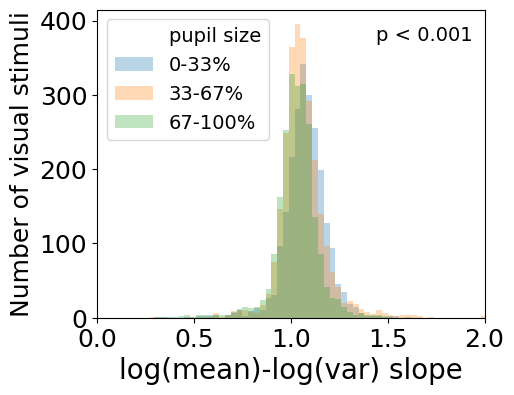

In [53]:
# Divide trials based on pupil area and fit mean-var slope

with open('ep_natural_scenes_pupil.pickle', 'rb') as f:
    ep_natural_scenes_pupil = pickle.load(f)

    list_mean_pupilarea_sess = dc(ep_natural_scenes_pupil['list_mean_pupilarea_sess'])
    list_mean_pupilarea_concat = dc(ep_natural_scenes_pupil['list_mean_pupilarea_concat'])
    list_slopes_flattened2 = dc(ep_natural_scenes_pupil['list_slopes_flattened2']) # num_div_pupil = 3

num_div_pupil = 3
list_percentiles = np.round(np.linspace(0, 1, num_div_pupil+1, endpoint=True) * 100) # e.g., num_div_pupil = 3 leads to [0, 33, 67, 100]
print(list_percentiles)

num_sess =32
num_trial_types = 119

fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(1, 0, alpha=0, label='pupil size') 

# list_slopes_flattened2 = np.empty(num_div_pupil, dtype=object)
for pupil_div_ind in range(num_div_pupil):
    print(f'\npupil_div_ind = {pupil_div_ind}')

    pupil_min = np.nanpercentile(list_mean_pupilarea_concat, list_percentiles[pupil_div_ind])
    pupil_max = np.nanpercentile(list_mean_pupilarea_concat, list_percentiles[pupil_div_ind+1])
    print(pupil_min, pupil_max)

    # # Iterate over all sessions
    # list_slopes_pupil_all_an_loglog = np.empty(num_sess, dtype=object) # stationary trials
    # for sess_ind, rate in enumerate(list_rate_all):
        
    #     if sess_ind > 6: # include only the sessions containing pupil area record & exclude low-quality sessions (0, 6)
    #         print(f'session index: {sess_ind}')
            
    #         rate = rate.loc[:, (list_mean_pupilarea_sess[sess_ind] >= pupil_min) & (list_mean_pupilarea_sess[sess_ind] <= pupil_max)].copy()
    #         if rate.shape[1] > 0: 
    #             # print(f'session {sess_ind} being processed...')

    #             rate = rate.sort_index(axis=1)
    #             stm = rate.columns.copy()

    #             # Multiply by delta t to convert to spike counts
    #             rate = rate * 0.25

    #             # Create a counting dictionary for each stimulus
    #             all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
    #             stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))
    #             # print(all_stm_unique.shape)

    #             # Compute mean & variance for each stimulus
    #             rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate)
    #             rate_sorted_FF = rate_sorted_var.div(rate_sorted_mean)

    #             rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate)

    #             # Calculate and collect linear slopes for all stimuli
    #             slopes = pd.DataFrame(np.full((2, num_trial_types), np.nan), columns=np.arange(-1, 118, 1).astype(int))
    #             for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):

    #                 # # arithmetic scale
    #                 # popt = np.polyfit(rate_sorted_mean.loc[neu_ind, :].astype(np.float32), \
    #                 #                     rate_sorted_FF.loc[neu_ind, :].astype(np.float32), 1)
    #                 # slopes[ind] = popt[0]

    #                 # loglog scale
    #                 bool_var_notzero = rate_sorted_var_coll.loc[:, trial_type] > 0
    #                 if bool_var_notzero.sum() > 10: # Minimum number of neurons for reliable linear regression
    #                     popt = np.polyfit(np.log10(rate_sorted_mean.loc[bool_var_notzero, trial_type].values).flatten().astype(np.float32), \
    #                                         np.log10(rate_sorted_var.loc[bool_var_notzero, trial_type].values).flatten().astype(np.float32), 1)
    #                     # popt = np.polyfit(np.log10(rate_sorted_mean.loc[:, trial_type].values).flatten().astype(np.float32), \
    #                     #                      np.log10(rate_sorted_var.loc[:, trial_type].values).flatten().astype(np.float32), 1)
                        
    #                     slopes.loc[:, trial_type] = popt.copy()
                
    #             list_slopes_pupil_all_an_loglog[sess_ind] = slopes.copy()

    # Histogram of slopes (all sessions)
    list_slopes_pupil_all_an_loglog_flattened = dc(list_slopes_flattened2[pupil_div_ind])
    # list_slopes_pupil_all_an_loglog_flattened = np.concatenate([slopes.iloc[0, :].to_numpy() for slopes in list_slopes_pupil_all_an_loglog if slopes is not None])
    bin_size = 0.03
    lower_bound, upper_bound = math.floor(np.nanmin(list_slopes_pupil_all_an_loglog_flattened)), \
        math.ceil(np.nanmax(list_slopes_pupil_all_an_loglog_flattened))

    ax.hist(list_slopes_pupil_all_an_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
            alpha=0.3, label=f'{int(list_percentiles[pupil_div_ind])}-{int(list_percentiles[pupil_div_ind+1])}%')
    # plt.axvline(1, color='r', linestyle='--')

    print(f'median = {np.nanmedian(list_slopes_pupil_all_an_loglog_flattened):.2f}')
    print(f'num_total_counts = {list_slopes_pupil_all_an_loglog_flattened[~np.isnan(list_slopes_pupil_all_an_loglog_flattened)].shape[0]}')

    list_slopes_flattened2[pupil_div_ind] = list_slopes_pupil_all_an_loglog_flattened.copy()

ax.set_xlabel('log(mean)-log(var) slope', fontsize=20)
ax.set_ylabel('Number of visual stimuli', fontsize=18)
# ax.set_xticks([0, 0.5, 1, 1.5, 2])
# ax.set_yticks([100, 300, 500, 700])
ax.tick_params('both', labelsize=18)

ax.set_xlim(0, 2)

ax.legend(loc='upper left', prop={'size': 14})

# Kruskal-Wallis test
pval_slopes_pupil = kruskal(*list_slopes_flattened2, nan_policy='omit').pvalue
print(f'Kruskal-Wallis p = {pval_slopes_pupil:.4f}')
ax.annotate(f'p < 0.001', xy=(0.72, 0.9), xycoords='axes fraction', fontsize=14)

plt.show()

In [54]:
# with open('ep_natural_scenes_pupil.pickle', 'wb') as f:
#     pickle.dump({'tree_variables': ['list_pupilarea_sess', 'list_mean_pupilarea_sess', 'list_mean_pupilarea_concat', 'list_slopes_flattened2'],
#                  'list_pupilarea_sess': list_pupilarea_sess, 'list_mean_pupilarea_sess': list_mean_pupilarea_sess,
#                  'list_mean_pupilarea_concat': list_mean_pupilarea_concat, 'list_slopes_flattened2': list_slopes_flattened2}, f)

## Figure S2C right

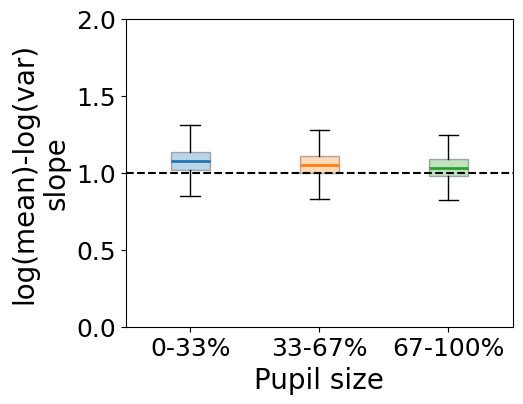

mean slopes [1.0742548681917656, 1.0608415743699164, 1.0298216730320926]
median slopes [1.0751770213317318, 1.0502241178514486, 1.032456725485196]


In [55]:
# box plot

with open('ep_natural_scenes_pupil.pickle', 'rb') as f:
    ep_natural_scenes_pupil = pickle.load(f)

    list_slopes_flattened2 = dc(ep_natural_scenes_pupil['list_slopes_flattened2']) # num_div_pupil = 3

num_div_pupil = 3
list_percentiles = np.round(np.linspace(0, 1, num_div_pupil+1, endpoint=True) * 100) # e.g., num_div_pupil = 3 leads to [0, 33, 67, 100]

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

list_slopes_flattened2 = [slopes_flattened[~np.isnan(slopes_flattened)] for slopes_flattened in list_slopes_flattened2]

box = ax.boxplot(list_slopes_flattened2, showfliers=False, tick_labels=[f'{int(list_percentiles[pupil_div_ind])}-{int(list_percentiles[pupil_div_ind+1])}%'
                                                                           for pupil_div_ind in range(num_div_pupil)], patch_artist=True)

# Set colors
box['boxes'][0].set(facecolor='tab:blue', alpha=0.3) # box color 
box['boxes'][1].set(facecolor='tab:orange', alpha=0.3)
box['boxes'][2].set(facecolor='tab:green', alpha=0.3)
# box['boxes'][3].set(facecolor='tab:red', alpha=0.3)
# box['boxes'][4].set(facecolor='tab:purple', alpha=0.3)
box['medians'][0].set(color='tab:blue', linewidth=2) # median line color
box['medians'][1].set(color='tab:orange', linewidth=2)
box['medians'][2].set(color='tab:green', linewidth=2)
# box['medians'][3].set(color='tab:red', linewidth=2)
# box['medians'][4].set(color='tab:purple', linewidth=2)

ax.axhline(1, color='k', linestyle='--')

ax.set_ylim(0, 2)
# ax.set_ylim(-1, 1)
ax.set_xlabel('Pupil size', fontsize=20)
ax.set_ylabel('log(mean)-log(var)\nslope', fontsize=20)
ax.tick_params('both', labelsize=18)
# plt.xticks(rotation=20)

plt.show()

print(f'mean slopes {[np.mean(slopes_flattened) for slopes_flattened in list_slopes_flattened2]}')
print(f'median slopes {[np.median(slopes_flattened) for slopes_flattened in list_slopes_flattened2]}')

## Figure S2D left

[  0.  33.  67. 100.]

pupil_div_ind = 0
0.00018799604417650418 0.0015244001880254105
session index: 7
session index: 8
session index: 9
session index: 10
session index: 11
session index: 12
session index: 13
session index: 14
session index: 15
session index: 16
session index: 17
session index: 18
session index: 19
session index: 20
session index: 21
session index: 22
session index: 23
session index: 24
session index: 25
session index: 26
session index: 27
session index: 28
session index: 29
session index: 30
session index: 31
median = 0.10
num_total_counts = 2194

pupil_div_ind = 1
0.0015244001880254105 0.0026514496347299172
session index: 7
session index: 8
session index: 9
session index: 10
session index: 11
session index: 12
session index: 13
session index: 14
session index: 15
session index: 16
session index: 17
session index: 18
session index: 19
session index: 20
session index: 21
session index: 22
session index: 23
session index: 24
session index: 25
session index: 26
session i

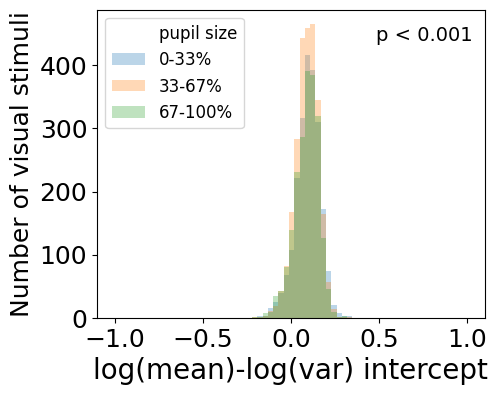

In [56]:
# Divide trials based on pupil area and fit mean-var slope

with open('ep_natural_scenes_pupil.pickle', 'rb') as f:
    ep_natural_scenes_pupil = pickle.load(f)

    list_mean_pupilarea_sess = dc(ep_natural_scenes_pupil['list_mean_pupilarea_sess'])
    list_mean_pupilarea_concat = dc(ep_natural_scenes_pupil['list_mean_pupilarea_concat'])

num_div_pupil = 3
list_percentiles = np.round(np.linspace(0, 1, num_div_pupil+1, endpoint=True) * 100) # e.g., num_div_pupil = 3 leads to [0, 33, 67, 100]
print(list_percentiles)

num_sess =32
num_trial_types = 119

fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(1, 0, alpha=0, label='pupil size') 

list_intcpts_flattened2 = np.empty(num_div_pupil, dtype=object)
for pupil_div_ind in range(num_div_pupil):
    print(f'\npupil_div_ind = {pupil_div_ind}')

    pupil_min = np.nanpercentile(list_mean_pupilarea_concat, list_percentiles[pupil_div_ind])
    pupil_max = np.nanpercentile(list_mean_pupilarea_concat, list_percentiles[pupil_div_ind+1])
    print(pupil_min, pupil_max)

    # Iterate over all sessions
    list_slopes_pupil_all_an_loglog = np.empty(num_sess, dtype=object) # stationary trials
    for sess_ind, rate in enumerate(list_rate_all):
        
        if sess_ind > 6: # include only the sessions containing pupil area record & exclude low-quality sessions (0, 6)
            print(f'session index: {sess_ind}')
            
            rate = rate.loc[:, (list_mean_pupilarea_sess[sess_ind] >= pupil_min) & (list_mean_pupilarea_sess[sess_ind] <= pupil_max)].copy()
            if rate.shape[1] > 0: 
                # print(f'session {sess_ind} being processed...')

                rate = rate.sort_index(axis=1)
                stm = rate.columns.copy()

                # Multiply by delta t to convert to spike counts
                rate = rate * 0.25

                # Create a counting dictionary for each stimulus
                all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
                stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))
                # print(all_stm_unique.shape)

                # Compute mean & variance for each stimulus
                rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate)
                rate_sorted_FF = rate_sorted_var.div(rate_sorted_mean)

                rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate)

                # Calculate and collect linear slopes for all stimuli
                slopes = pd.DataFrame(np.full((2, num_trial_types), np.nan), columns=np.arange(-1, 118, 1).astype(int))
                for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):

                    # # arithmetic scale
                    # popt = np.polyfit(rate_sorted_mean.loc[neu_ind, :].astype(np.float32), \
                    #                     rate_sorted_FF.loc[neu_ind, :].astype(np.float32), 1)
                    # slopes[ind] = popt[0]

                    # loglog scale
                    bool_var_notzero = rate_sorted_var_coll.loc[:, trial_type] > 0
                    if bool_var_notzero.sum() > 10: # Minimum number of neurons for reliable linear regression
                        popt = np.polyfit(np.log10(rate_sorted_mean.loc[bool_var_notzero, trial_type].values).flatten().astype(np.float32), \
                                            np.log10(rate_sorted_var.loc[bool_var_notzero, trial_type].values).flatten().astype(np.float32), 1)
                        # popt = np.polyfit(np.log10(rate_sorted_mean.loc[:, trial_type].values).flatten().astype(np.float32), \
                        #                      np.log10(rate_sorted_var.loc[:, trial_type].values).flatten().astype(np.float32), 1)
                        
                        slopes.loc[:, trial_type] = popt.copy()
                
                list_slopes_pupil_all_an_loglog[sess_ind] = slopes.copy()

    # Histogram of slopes (all sessions)
    list_intcpts_pupil_all_an_loglog_flattened = np.concatenate([slopes.iloc[1, :].to_numpy() for slopes in list_slopes_pupil_all_an_loglog if slopes is not None])
    bin_size = 0.03
    lower_bound, upper_bound = math.floor(np.nanmin(list_intcpts_pupil_all_an_loglog_flattened)), \
        math.ceil(np.nanmax(list_intcpts_pupil_all_an_loglog_flattened))

    ax.hist(list_intcpts_pupil_all_an_loglog_flattened, bins=np.arange(lower_bound, upper_bound, bin_size), range=(lower_bound, upper_bound), \
            alpha=0.3, label=f'{int(list_percentiles[pupil_div_ind])}-{int(list_percentiles[pupil_div_ind+1])}%')
    # plt.axvline(1, color='r', linestyle='--')

    print(f'median = {np.nanmedian(list_intcpts_pupil_all_an_loglog_flattened):.2f}')
    print(f'num_total_counts = {list_intcpts_pupil_all_an_loglog_flattened[~np.isnan(list_intcpts_pupil_all_an_loglog_flattened)].shape[0]}')

    list_intcpts_flattened2[pupil_div_ind] = list_intcpts_pupil_all_an_loglog_flattened.copy()

ax.set_xlabel('log(mean)-log(var) intercept', fontsize=20)
ax.set_ylabel('Number of visual stimuli', fontsize=18)
# ax.set_xticks([0, 0.5, 1, 1.5, 2])
# ax.set_yticks([100, 300, 500, 700])
ax.tick_params('both', labelsize=18)

# ax.set_xlim(0, 2)

ax.legend(loc='upper left', prop={'size': 12})

# Kruskal-Wallis test
pval_slopes_pupil = kruskal(*list_intcpts_flattened2, nan_policy='omit').pvalue
print(f'Kruskal-Wallis p = {pval_slopes_pupil:.4f}')
ax.annotate(f'p < 0.001', xy=(0.72, 0.9), xycoords='axes fraction', fontsize=14)

plt.show()

## Figure S2D right

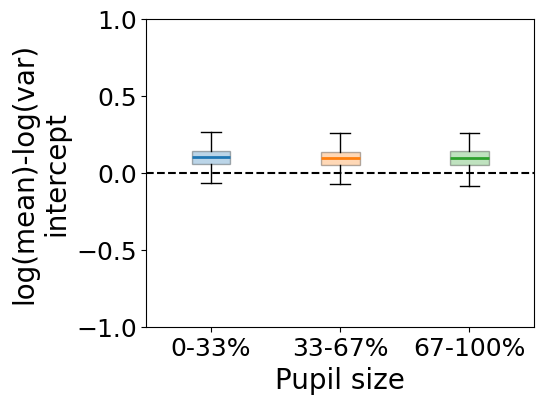

mean intercepts [0.09708375708475946, 0.09098649763796608, 0.0891784359472402]
median intercepts [0.1006886567634034, 0.09457310110106583, 0.09810647474957931]


In [57]:
# box plot

num_div_pupil = 3
list_percentiles = np.round(np.linspace(0, 1, num_div_pupil+1, endpoint=True) * 100) # e.g., num_div_pupil = 3 leads to [0, 33, 67, 100]

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

list_intcpts_flattened2 = [intcpts_flattened[~np.isnan(intcpts_flattened)] for intcpts_flattened in list_intcpts_flattened2]

box = ax.boxplot(list_intcpts_flattened2, showfliers=False, tick_labels=[f'{int(list_percentiles[pupil_div_ind])}-{int(list_percentiles[pupil_div_ind+1])}%'
                                                                           for pupil_div_ind in range(num_div_pupil)], patch_artist=True)

# Set colors
box['boxes'][0].set(facecolor='tab:blue', alpha=0.3) # box color 
box['boxes'][1].set(facecolor='tab:orange', alpha=0.3)
box['boxes'][2].set(facecolor='tab:green', alpha=0.3)
# box['boxes'][3].set(facecolor='tab:red', alpha=0.3)
# box['boxes'][4].set(facecolor='tab:purple', alpha=0.3)
box['medians'][0].set(color='tab:blue', linewidth=2) # median line color
box['medians'][1].set(color='tab:orange', linewidth=2)
box['medians'][2].set(color='tab:green', linewidth=2)
# box['medians'][3].set(color='tab:red', linewidth=2)
# box['medians'][4].set(color='tab:purple', linewidth=2)

ax.axhline(0, color='k', linestyle='--')

# ax.set_ylim(0, 2)
ax.set_ylim(-1, 1)
ax.set_xlabel('Pupil size', fontsize=20)
ax.set_ylabel('log(mean)-log(var)\nintercept', fontsize=20)
ax.tick_params('both', labelsize=18)
# plt.xticks(rotation=20)

plt.show()

print(f'mean intercepts {[np.mean(intcpts_flattened) for intcpts_flattened in list_intcpts_flattened2]}')
print(f'median intercepts {[np.median(intcpts_flattened) for intcpts_flattened in list_intcpts_flattened2]}')